In [1]:
import os, sys
sys.path.append("../../common/")
from python_tools import *
import scipy.optimize
import numba_scipy
from numba import jit, float32

python tools loaded.


In [2]:
%matplotlib notebook

In [3]:
cov_file = uproot.open("/Users/wketchum/Data/MicroBooNE/LEEFits/dllee_fd2/total_sys_pred.SBNcovar.root")
mc_file = uproot.open("/Users/wketchum/Data/MicroBooNE/LEEFits/dllee_fd2/sens_pred.SBNspec.root")
data_file = uproot.open("/Users/wketchum/Data/MicroBooNE/LEEFits/dllee_fd2/fakedata.SBNspec.root")

In [4]:
print(cov_file.keys())
print(mc_file.keys())
print(data_file.keys())

[b'full_covariance;1', b'frac_covariance;1', b'full_correlation;1', b'collapsed_covariance;1', b'collapsed_frac_covariance;1', b'collapsed_correlation;1']
[b'nu_uBooNE_1e1p_bnb;1', b'nu_uBooNE_1e1p_lee;1', b'nu_uBooNE_1mu1p_bnb;1']
[b'nu_uBooNE_1e1p_bnb;1', b'nu_uBooNE_1e1p_lee;1', b'nu_uBooNE_1mu1p_bnb;1']


In [5]:
NUE_EXP = mc_file["nu_uBooNE_1e1p_bnb"].numpy()[0]
NUMU_EXP = mc_file["nu_uBooNE_1mu1p_bnb"].numpy()[0]
SIG_EXP = mc_file["nu_uBooNE_1e1p_lee"].numpy()[0]

DATA_EXP = np.append(np.copy(NUE_EXP),NUMU_EXP)
SIG_EXP = np.append(SIG_EXP,np.full_like(NUMU_EXP,0))

In [6]:
NUE_OBS = data_file["nu_uBooNE_1e1p_bnb"].numpy()[0]
NUMU_OBS = data_file["nu_uBooNE_1mu1p_bnb"].numpy()[0]
DATA_OBS = np.append(np.copy(NUE_OBS),NUMU_OBS)

In [7]:
m = cov_file["collapsed_covariance"]
M_COV_SYS = np.copy(m._fElements.reshape(m._fNrows, m._fNcols))
M_COV_SYS = np.float32(M_COV_SYS)
M_COV_NUE_SYS = M_COV_SYS[:10,:10]
M_COV_NUMU_SYS = M_COV_SYS[10:,10:]
M_COV_EM_SYS = M_COV_SYS[:10,10:]
M_COV_ME_SYS = M_COV_SYS[10:,:10]

M_COV_SYS_INV = np.linalg.inv(M_COV_SYS)
M_COV_NUE_SYS_INV = np.linalg.inv(M_COV_NUE_SYS)
M_COV_NUMU_SYS_INV = np.linalg.inv(M_COV_NUMU_SYS)

M_COV = np.copy(M_COV_SYS) + np.diagflat(DATA_EXP)
M_COV_SIG = np.copy(M_COV_SYS) + np.diagflat(DATA_EXP+SIG_EXP)

M_COV_NUE = M_COV[:10,:10]
M_COV_NUMU = M_COV[10:,10:]
M_COV_EM = M_COV[:10,10:]
M_COV_ME = M_COV[10:,:10]

M_COV_INV = np.linalg.inv(M_COV)
M_COV_SIG_INV = np.linalg.inv(M_COV_SIG)
M_COV_NUE_INV = np.linalg.inv(M_COV_NUE)
M_COV_NUMU_INV = np.linalg.inv(M_COV_NUMU)

IDENTITY_FULL = np.identity(len(SIG_EXP))

In [8]:
#useful for speedups
M_INV_S = np.matmul(M_COV_INV,np.diagflat(SIG_EXP))
M_INV_S_M_INV = np.matmul(M_INV_S,M_COV_INV)

In [9]:
def M_COV_INV_FAST_FULL(mu=1.0):
    #just in case you ask for zero...
    if np.isclose(mu,0.0): 
        return M_COV_INV
    else:
        return M_COV_INV - mu*np.matmul(np.linalg.inv(IDENTITY_FULL+mu*M_INV_S),
                                        M_INV_S_M_INV)

In [10]:
def CHI2(diff,m_cov_inv):
    return np.matmul(np.transpose(diff),np.matmul(m_cov_inv,diff))

def COND_EXP(diff1,exp2,m_cov_11_inv,m_cov_21):
    return exp2 + np.matmul(m_cov_21,np.matmul(m_cov_11_inv,diff1))

def COND_COV(m_cov_22,m_cov_11_inv,m_cov_12,m_cov_21):
    return m_cov_22 - np.matmul(m_cov_21,np.matmul(m_cov_11_inv,m_cov_12))

def CHI2_SIG_FULL(x,data):
    return CHI2(data - (x*SIG_EXP+DATA_EXP),M_COV_INV_FAST_FULL(x))

In [265]:
NUE_EXP_COND = COND_EXP(NUMU_OBS-NUMU_EXP,NUE_EXP,M_COV_NUMU_INV,M_COV_EM)
#M_COV_COND_SYS = COND_COV(M_COV_NUE_SYS,M_COV_NUMU_SYS_INV,M_COV_ME_SYS,M_COV_EM_SYS)
#M_COV_COND = np.copy(M_COV_COND_SYS) + np.diagflat(NUE_EXP_COND)
#M_COV_COND_INV = np.linalg.inv(M_COV_COND)

M_COV_COND_SYS = COND_COV(M_COV_NUE_SYS,np.linalg.inv(M_COV_NUMU_SYS+np.diagflat(NUMU_EXP)),M_COV_ME_SYS,M_COV_EM_SYS)
M_COV_COND = np.copy(M_COV_COND_SYS) + np.diagflat(NUE_EXP_COND)
M_COV_COND_INV = np.linalg.inv(M_COV_COND)

SIG_EXP_COND = SIG_EXP[:10]# * (NUE_EXP_COND)/NUE_EXP
M_COV_SIG_COND = np.copy(M_COV_COND_SYS) + np.diagflat(SIG_EXP_COND)+np.diagflat(NUE_EXP_COND)
M_COV_SIG_COND_INV = np.linalg.inv(M_COV_SIG_COND)


In [266]:
IDENTITY_COND = np.identity(len(SIG_EXP_COND))
M_INV_S_COND = np.matmul(M_COV_COND_INV,np.diagflat(SIG_EXP_COND))
M_INV_S_M_INV_COND = np.matmul(M_INV_S_COND,M_COV_COND_INV)

In [267]:
def M_COV_INV_FAST_COND(mu=1.0):
    #just in case you ask for zero...
    if np.isclose(mu,0.0): 
        return M_COV_COND_INV
    else:
        return M_COV_COND_INV - mu*np.matmul(np.linalg.inv(IDENTITY_COND+mu*M_INV_S_COND),
                                        M_INV_S_M_INV_COND)
    
def CHI2_SIG_COND(x,data):
    return CHI2(data - (x*SIG_EXP_COND+NUE_EXP_COND),M_COV_INV_FAST_COND(x))



<IPython.core.display.Javascript object>


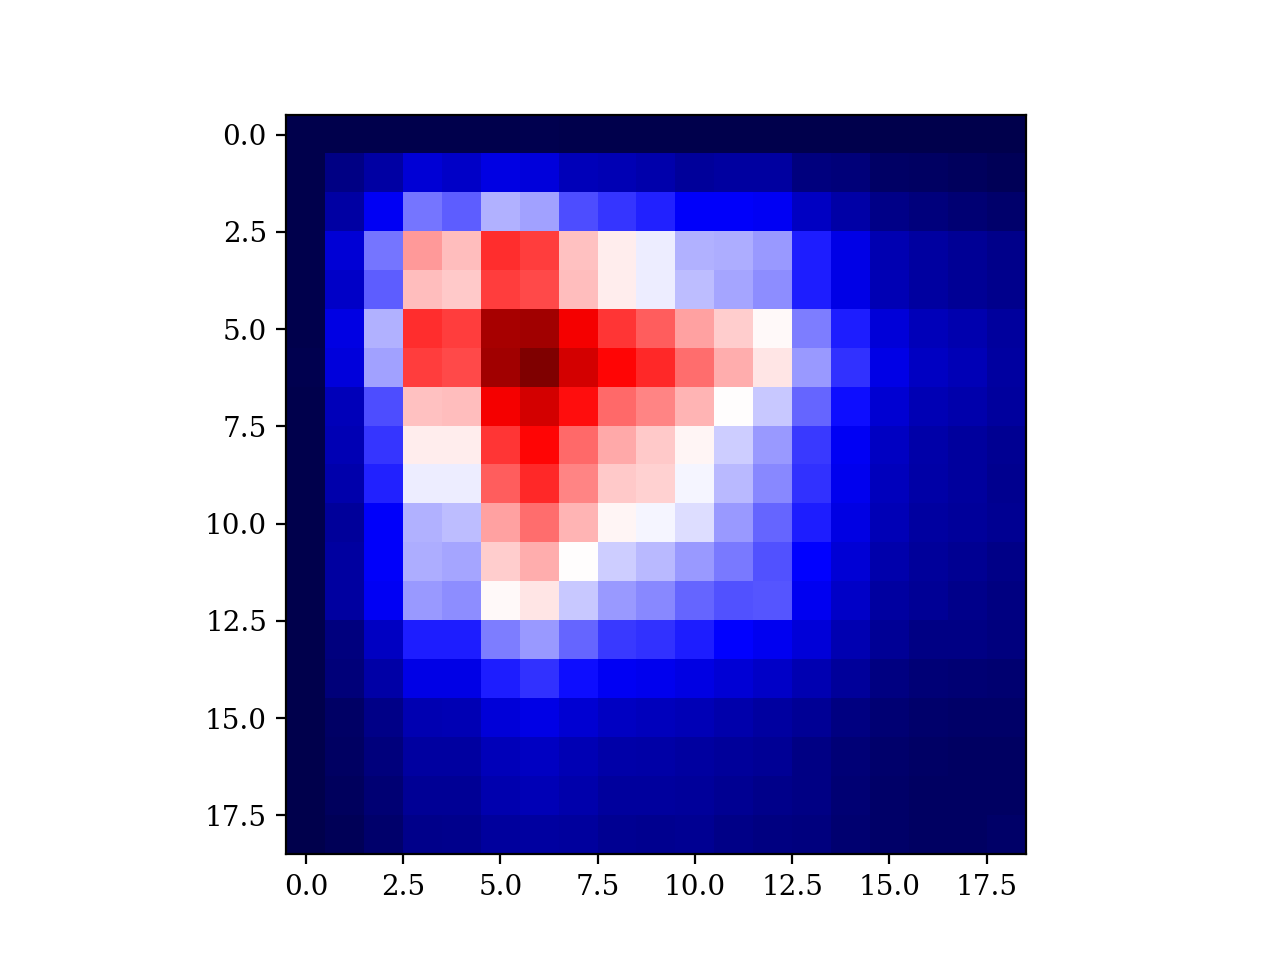

In [171]:
fig = plt.subplots()

#plt.imshow(M_COV,origin={'lower','lower'})
plt.imshow(M_COV_NUMU_SYS)

In [15]:
def GET_PE(exp,m_cov_sys):
    return np.random.poisson(np.clip(np.random.multivariate_normal(exp, m_cov_sys),0,1e9))

In [262]:
def CHI2_SIG(x,data,sig,exp,m_cov_inv):
    return CHI2(data - (x*sig+exp),m_cov_inv)

def FIT_PE_CALC_COND(pe,mu_true):
    exp_cond = COND_EXP(pe[10:]-NUMU_EXP,NUE_EXP,M_COV_NUMU_INV,M_COV_EM)
    m_cov_cond_sys = COND_COV(M_COV_NUE_SYS,np.linalg.inv(M_COV_NUMU_SYS+np.diagflat(pe[10:])),M_COV_ME_SYS,M_COV_EM_SYS)
    m_cov_cond = np.copy(m_cov_cond_sys) + np.diagflat(exp_cond)
    m_cov_cond_inv = np.linalg.inv(m_cov_cond)

    x0 = [0.1]
    res = scipy.optimize.minimize(CHI2_SIG,x0,
                                  args=(pe[:10],SIG_EXP[:10],exp_cond,m_cov_cond_inv),
                                  bounds=[(0,100.)])
    chi2_h0 = CHI2_SIG(0,pe[:10],SIG_EXP[:10],exp_cond,m_cov_cond_inv)
    chi2_h1 = CHI2_SIG(mu_true,pe[:10],SIG_EXP[:10],exp_cond,m_cov_cond_inv)
    chi2_hb = CHI2_SIG(res.x[0],pe[:10],SIG_EXP[:10],exp_cond,m_cov_cond_inv)
    return res.x[0], chi2_h0, chi2_h1, chi2_hb

In [268]:
def RUN_PES_FULL(n_pes,mu_true,verbose=False):
    
    tot_exp = DATA_EXP+mu_true*SIG_EXP
    df_pes = pd.DataFrame(index=np.arange(0,n_pes),columns=["mu_true","chi2_h0","chi2_hs","chi2_h1","chi2_hb","chi2_diff","mu_fit","pe_data"])
    
    m_cov_true_inv = M_COV_INV_FAST_FULL(mu_true)
    
    for i_pe in range(int(n_pes)):
        my_pe = GET_PE(tot_exp,M_COV_SYS)
        chi2_h0 = CHI2(my_pe-DATA_EXP,M_COV_INV)
        chi2_hs = CHI2(my_pe-(SIG_EXP+DATA_EXP),M_COV_SIG_INV)
        chi2_h1 = CHI2(my_pe-tot_exp,m_cov_true_inv)
        x0 = [np.max([0.1,mu_true])]
        res = scipy.optimize.minimize(CHI2_SIG_FULL,x0,
                                      args=(my_pe),
                                      bounds=[(0,100.)])
        chi2_hb = CHI2_SIG_FULL(res.x[0],my_pe)
        df_pes.loc[i_pe] = [mu_true,chi2_h0,chi2_hs,chi2_h1,chi2_hb,chi2_h1-chi2_hb,res.x[0],my_pe]
        i_pe+=1
        
        if(i_pe%1000==0 and verbose):
            print("\t\t\t finished PE %d"%i_pe)
        
    return df_pes

def RUN_PES_COND(n_pes,mu_true,verbose=False):
    
    tot_exp = NUE_EXP_COND+mu_true*SIG_EXP_COND
    df_pes = pd.DataFrame(index=np.arange(0,n_pes),columns=["mu_true","chi2_h0","chi2_hs","chi2_h1","chi2_hb","chi2_diff","mu_fit","pe_data"])
    
    m_cov_true_inv = M_COV_INV_FAST_COND(mu_true)
    
    for i_pe in range(int(n_pes)):
        my_pe = GET_PE(tot_exp,M_COV_COND_SYS)
        chi2_h0 = CHI2(my_pe-NUE_EXP_COND,M_COV_COND_INV)
        chi2_hs = CHI2(my_pe-(SIG_EXP_COND+NUE_EXP_COND),M_COV_SIG_COND_INV)
        chi2_h1 = CHI2(my_pe-tot_exp,m_cov_true_inv)
        x0 = [np.max([0.1,mu_true])]
        res = scipy.optimize.minimize(CHI2_SIG_COND,x0,
                                      args=(my_pe),
                                      bounds=[(0,100.)])
        chi2_hb = CHI2_SIG_COND(res.x[0],my_pe)
        df_pes.loc[i_pe] = [mu_true,chi2_h0,chi2_hs,chi2_h1,chi2_hb,chi2_h1-chi2_hb,res.x[0],my_pe]
        i_pe+=1
        
        if(i_pe%1000==0 and verbose):
            print("\t\t\t finished PE %d"%i_pe)
        
    return df_pes

In [ ]:
RUN_PES_FULL(100,0.5,True)

In [269]:
RUN_PES_COND(100,1.0,True)

/Library/Python/3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


mu_true  chi2_h0  chi2_hs  chi2_h1  chi2_hb  chi2_diff    mu_fit  \
0        1  32.3255  8.40612  8.40612  7.58666   0.819452   1.35908   
1        1  28.9699  9.90585  9.90585  9.84991  0.0559367  0.911573   
2        1  22.9228  13.6959  13.6959  12.2305    1.46544  0.597647   
3        1  30.5691  10.2003  10.2003  10.1415  0.0588027  0.912601   
4        1   39.824  6.75192  6.75192  6.01034   0.741579   1.31705   
..     ...      ...      ...      ...      ...        ...       ...   
95       1  37.8575  15.7246  15.7246  14.5981    1.12644   1.42861   
96       1  57.0725  11.2728  11.2728  10.3207   0.952082   1.34656   
97       1  45.1971  7.22251  7.22251  6.20263    1.01988   1.37472   
98       1  78.4764  11.6798  11.6798  8.46325    3.21658   1.61243   
99       1  33.0434   8.3947   8.3947  8.34842    0.04628   1.07948   

                              pe_data  
0    [3, 16, 11, 6, 7, 9, 4, 9, 2, 0]  
1    [5, 7, 7, 7, 11, 11, 7, 8, 3, 4]  
2      [4, 8, 2, 5, 5, 2, 4, 4, 0, 2]  
3     [5, 9, 5, 9, 5, 12, 5, 6, 6, 2]  
4     [5, 15, 7, 9, 4, 4, 6, 3, 3, 1]  
..                                ...  
95  [1, 18, 10, 10, 0, 6, 8, 6, 4, 1]  
96   [7, 11, 4, 9, 10, 4, 6, 6, 4, 1]  
97   [6, 10, 12, 6, 8, 4, 6, 5, 2, 2]  
98    [8, 15, 6, 7, 4, 6, 5, 4, 5, 2]  
99    [5, 11, 8, 6, 9, 6, 8, 3, 6, 2]  

[100 rows x 8 columns]

In [20]:
TRUE_VALS = np.arange(0,5.05,0.05)
N_PES = 5e4

In [271]:
TRUE_VALS2 = np.arange(0,5.1,0.1)
N_PES2 = 1e4

In [82]:
CHI2(DATA_OBS-DATA_EXP,M_COV_INV)

63.920378925247995

In [83]:
CHI2(NUMU_OBS-NUMU_EXP,M_COV_NUMU_INV)

40.48557410886951

In [21]:
df_pes_tot = pd.DataFrame()
for x in TRUE_VALS:
    print("\tRunning x=%f"%x)
    df_pes_tot = df_pes_tot.append(RUN_PES_FULL(N_PES,x,True))

	Running x=0.000000


/Library/Python/3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 460

			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=0.400000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000

			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=0.750000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000

			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=1.150000
			 finished PE 1000
			 finished PE 2000
			 finished PE

			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=1.500000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000

			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=1.850000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000

			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=2.250000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000

			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=2.600000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000

			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 

			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=3.350000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000

			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=3.700000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000

			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=4.100000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6

			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000
			 finished PE 45000
			 finished PE 46000
			 finished PE 47000
			 finished PE 48000
			 finished PE 49000
			 finished PE 50000
	Running x=4.450000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000

			 finished PE 50000
	Running x=4.800000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
			 finished PE 11000
			 finished PE 12000
			 finished PE 13000
			 finished PE 14000
			 finished PE 15000
			 finished PE 16000
			 finished PE 17000
			 finished PE 18000
			 finished PE 19000
			 finished PE 20000
			 finished PE 21000
			 finished PE 22000
			 finished PE 23000
			 finished PE 24000
			 finished PE 25000
			 finished PE 26000
			 finished PE 27000
			 finished PE 28000
			 finished PE 29000
			 finished PE 30000
			 finished PE 31000
			 finished PE 32000
			 finished PE 33000
			 finished PE 34000
			 finished PE 35000
			 finished PE 36000
			 finished PE 37000
			 finished PE 38000
			 finished PE 39000
			 finished PE 40000
			 finished PE 41000
			 finished PE 42000
			 finished PE 43000
			 finished PE 44000

In [272]:
df_pes_cond = pd.DataFrame()
for x in TRUE_VALS2:
    print("\tRunning x=%f"%x)
    df_pes_cond = df_pes_cond.append(RUN_PES_COND(N_PES2,x,True))

	Running x=0.000000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=0.100000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=0.200000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=0.300000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=0.400000
			 finished PE 1000
			 finished PE 2000
			 finished P

			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=3.600000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=3.700000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=3.800000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished PE 9000
			 finished PE 10000
	Running x=3.900000
			 finished PE 1000
			 finished PE 2000
			 finished PE 3000
			 finished PE 4000
			 finished PE 5000
			 finished PE 6000
			 finished PE 7000
			 finished PE 8000
			 finished 

In [23]:
df_pes_tot

mu_true  chi2_h0  chi2_hs  chi2_h1  chi2_hb    chi2_diff    mu_fit  \
0.0           0   26.528  36.2698   26.528   26.528            0         0   
1.0           0   35.895  41.4735   35.895  35.7451      0.14982  0.099245   
2.0           0  34.5446  42.9376  34.5446  34.5446            0         0   
3.0           0  29.2739  29.5186  29.2739  27.1734      2.10043  0.393188   
4.0           0  21.8838  29.0496  21.8838  21.8838            0         0   
...         ...      ...      ...      ...      ...          ...       ...   
49995.0       5   378.43   129.61  23.3195  23.2847    0.0348364   5.12507   
49996.0       5  286.699  108.878  22.5713  22.5324    0.0388593   4.86661   
49997.0       5  273.773  74.9464  22.4077  19.3329      3.07473   3.84793   
49998.0       5  421.777  123.273   22.974  22.8064     0.167574   4.73638   
49999.0       5  332.292  122.102  23.5185  23.5175  0.000970342    5.0207   

                                                   pe_data  
0.0      [1, 2, 4, 7, 5, 6, 3, 4, 2, 1, 1, 44, 85, 129,...  
1.0      [1, 9, 4, 4, 6, 8, 7, 2, 3, 1, 0, 45, 98, 192,...  
2.0      [0, 3, 3, 6, 10, 6, 1, 9, 3, 2, 1, 41, 57, 91,...  
3.0      [2, 10, 6, 10, 7, 4, 6, 2, 4, 2, 1, 56, 102, 1...  
4.0      [0, 7, 2, 7, 6, 5, 7, 2, 1, 3, 1, 47, 80, 168,...  
...                                                    ...  
49995.0  [12, 44, 19, 18, 12, 12, 8, 11, 3, 4, 1, 50, 1...  
49996.0  [7, 40, 21, 20, 8, 9, 9, 6, 0, 1, 2, 36, 88, 1...  
49997.0  [14, 28, 17, 14, 9, 12, 4, 4, 4, 1, 1, 49, 107...  
49998.0  [16, 34, 20, 11, 12, 4, 4, 3, 1, 1, 1, 29, 87,...  
49999.0  [9, 39, 21, 18, 8, 2, 6, 3, 2, 0, 1, 18, 52, 1...  

[5050000 rows x 8 columns]

In [280]:
df_pes_cond

mu_true     chi2_h0     chi2_hs  chi2_h1  chi2_hb  chi2_diff    mu_fit  \
0.0          0   10.708596   18.640711  10.7086  10.7086   0.000000  0.000000   
1.0          0   11.163294   12.049444  11.1633  9.68369   1.479601  0.357962   
2.0          0   13.938277   24.289575  13.9383  13.9383   0.000000  0.000000   
3.0          0   10.843821   13.112949  10.8438  9.93503   0.908791  0.273483   
4.0          0   17.966721   19.374082  17.9667  16.2227   1.744047  0.311910   
...        ...         ...         ...      ...      ...        ...       ...   
9995.0       5  481.806082  149.731059  12.1385  11.3112   0.827328  5.604600   
9996.0       5  457.484672  107.193971  7.85358   7.6782   0.175381  4.725477   
9997.0       5  400.564995  131.437871  9.48002  8.95956   0.520454  5.484192   
9998.0       5  432.127075  119.869763  3.51758  3.32061   0.196964  5.295157   
9999.0       5  510.079171  131.525885  4.34321  4.19918   0.144028  5.246319   

                                      pe_data  
0.0            [0, 3, 8, 3, 5, 5, 2, 6, 0, 4]  
1.0           [1, 8, 7, 9, 2, 12, 4, 5, 1, 1]  
2.0           [0, 4, 1, 5, 8, 8, 3, 11, 2, 1]  
3.0            [1, 7, 9, 3, 8, 9, 2, 7, 5, 5]  
4.0            [2, 6, 7, 9, 4, 9, 6, 3, 9, 3]  
...                                       ...  
9995.0  [13, 50, 17, 14, 10, 16, 5, 10, 3, 2]  
9996.0   [17, 36, 13, 15, 10, 11, 9, 4, 2, 2]  
9997.0   [11, 45, 23, 16, 13, 7, 11, 3, 5, 3]  
9998.0    [15, 35, 25, 19, 12, 8, 4, 5, 3, 3]  
9999.0     [17, 38, 23, 15, 7, 9, 6, 5, 2, 1]  

[510000 rows x 8 columns]

In [25]:
df_pes_tot.to_hdf("/Users/wketchum/Data/MicroBooNE/LEEFits/fd2_dfs.h5","df_pes_tot")
df_pes_cond.to_hdf("/Users/wketchum/Data/MicroBooNE/LEEFits/fd2_dfs.h5","df_pes_cond")

/Library/Python/3.8/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['mu_true', 'chi2_h0', 'chi2_hs', 'chi2_h1', 'chi2_hb', 'chi2_diff',
       'mu_fit', 'pe_data'],
      dtype='object')]

  pytables.to_hdf(


In [26]:
SIGMA1 = scipy.stats.norm(0,1).cdf(1)-scipy.stats.norm(0,1).cdf(-1)
SIGMA2 = scipy.stats.norm(0,1).cdf(2)-scipy.stats.norm(0,1).cdf(-2)
SIGMA3 = scipy.stats.norm(0,1).cdf(3)-scipy.stats.norm(0,1).cdf(-3)

In [27]:
def GET_CRITICAL_VALUES(true_vals,quantiles,df_pes):

    critical_vals = np.empty((len(quantiles),len(true_vals)))

    for ix in range(len(true_vals)):
        x = true_vals[ix]
        qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.0001,x+0.0001))
        df_pes['mu_true'] = df_pes['mu_true'].astype(float)
        cvals = np.quantile(df_pes.query(qstring)["chi2_diff"],quantiles)
        
        for iv in range(len(cvals)):
            critical_vals[iv,ix] = cvals[iv]

    return critical_vals

In [28]:
def CHI2_DIFF_FULL(data,x_vals):
    x0 = [0.1]
    res = scipy.optimize.minimize(CHI2_SIG_FULL,x0,
                                  args=(data),
                                        bounds=[(0,100.)])
    chi2_hb_obs = CHI2_SIG_FULL(res.x[0],data=data)
    
    chi2_diff = np.empty(len(x_vals))
    for ix in range(len(x_vals)):
        chi2_diff[ix] = CHI2_SIG_FULL(x_vals[ix],data=data)-chi2_hb_obs
    return chi2_diff

def CHI2_DIFF_COND(data,x_vals):
    x0 = [0.1]
    res = scipy.optimize.minimize(CHI2_SIG_COND,x0,
                                  args=(data),
                                        bounds=[(0,100.)])
    chi2_hb_obs = CHI2_SIG_COND(res.x[0],data=data)
    
    chi2_diff = np.empty(len(x_vals))
    for ix in range(len(x_vals)):
        chi2_diff[ix] = CHI2_SIG_COND(x_vals[ix],data=data)-chi2_hb_obs
    return chi2_diff

def GET_FC_INTERVAL(chi2_diff,true_vals,critical_vals):
    intervals = []
    for ic in range(len(critical_vals)):
        vals = np.where(chi2_diff<critical_vals[ic],true_vals,np.nan)
        vals = vals[~np.isnan(vals)]
        if len(vals)==0:
            intervals.append((-1,9999))
        else:
            intervals.append((np.amin(vals),np.amax(vals)))
    return intervals

def CALC_FC_INTERVAL_FULL(data,x_vals,critical_vals):
    return GET_FC_INTERVAL(CHI2_DIFF_FULL(data,x_vals),x_vals,critical_vals)

def CALC_FC_INTERVAL_COND(data,x_vals,critical_vals):
    return GET_FC_INTERVAL(CHI2_DIFF_COND(data,x_vals),x_vals,critical_vals)

In [29]:
critical_vals_tot = GET_CRITICAL_VALUES(TRUE_VALS,[SIGMA1,SIGMA2,SIGMA3],df_pes_tot)

In [30]:
critical_vals_cond = GET_CRITICAL_VALUES(TRUE_VALS2,[SIGMA1,SIGMA2,SIGMA3],df_pes_cond)

In [31]:
print(CALC_FC_INTERVAL_FULL(df_pes_tot.iloc[0]["pe_data"],TRUE_VALS,critical_vals_tot))
print(CALC_FC_INTERVAL_COND(df_pes_cond.iloc[0]["pe_data"],TRUE_VALS,critical_vals_cond))

[(0.0, 0.1), (0.0, 0.5), (0.0, 1.1500000000000001)]
[(0.0, 0.30000000000000004), (0.0, 0.75), (0.0, 1.35)]


In [32]:
CALC_FC_INTERVAL_FULL(DATA_OBS,TRUE_VALS,critical_vals_tot)

[(0.45, 1.1), (0.15000000000000002, 1.6500000000000001), (0.0, 2.35)]

In [33]:
CALC_FC_INTERVAL_COND(NUE_OBS,TRUE_VALS2,critical_vals_cond)

[(0.45, 1.1), (0.2, 1.6500000000000001), (0.0, 2.3000000000000003)]

In [34]:
x0 = [0.1]
res = scipy.optimize.minimize(CHI2_SIG_FULL,x0,
                                  args=(DATA_OBS),
                                        bounds=[(0,100.)])
print(res)

      fun: 53.719172124635975
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.42108546e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 8
     njev: 12
   status: 0
  success: True
        x: array([0.72961969])


In [35]:
x0 = [0.1]
res = scipy.optimize.minimize(CHI2_SIG_COND,x0,
                                  args=(NUE_OBS),
                                        bounds=[(0,100.)])
print(res)

      fun: 12.636241967303441
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.76996257e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 20
      nit: 6
     njev: 10
   status: 0
  success: True
        x: array([0.74505494])


<IPython.core.display.Javascript object>


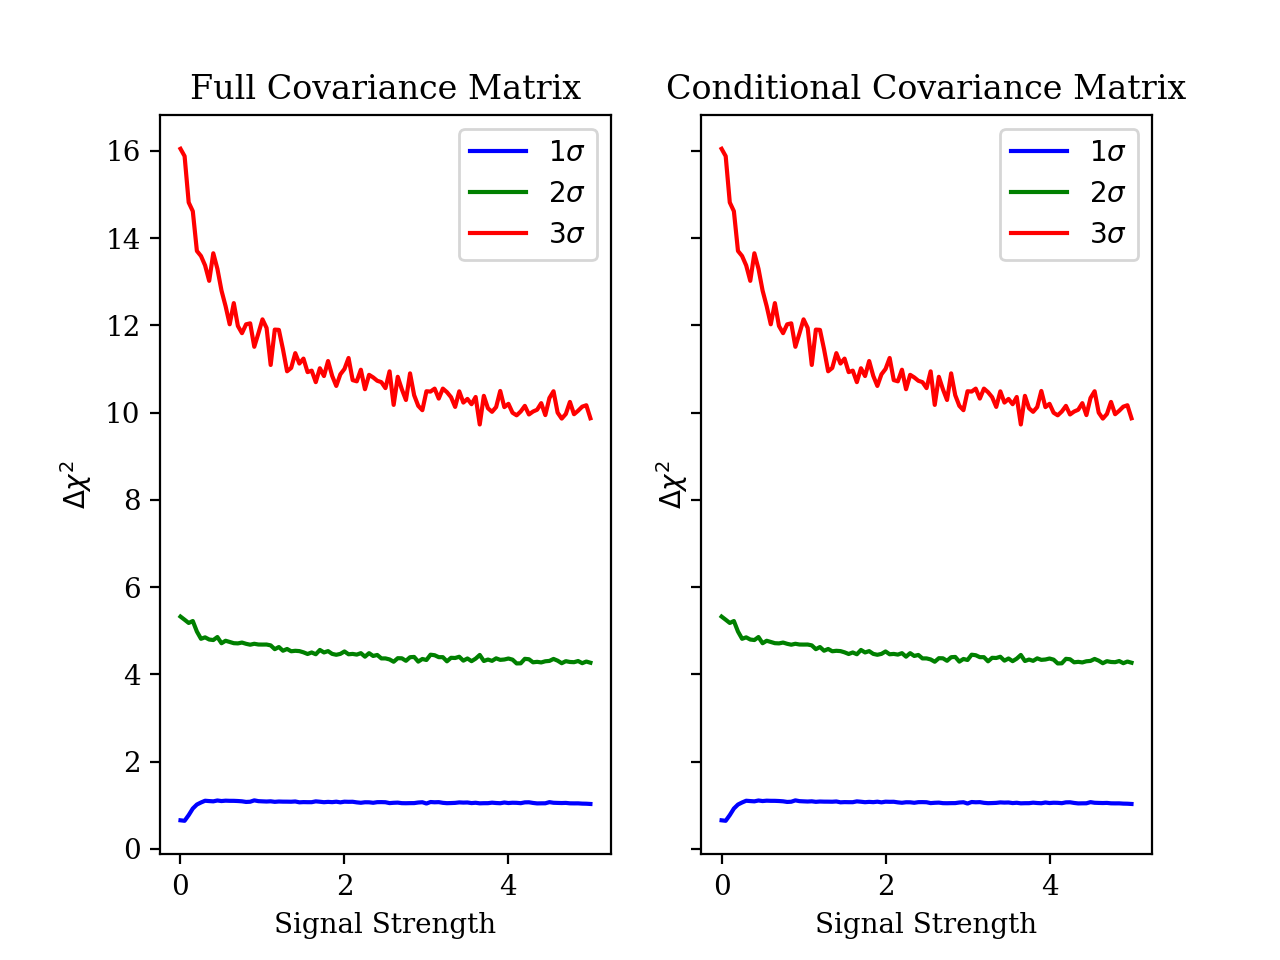

In [36]:
fig,ax = plt.subplots(1,2,sharey=True)

#bins=np.arange(0,50,1)

ax[0].plot(TRUE_VALS,critical_vals_tot[0],label="$1\sigma$")
ax[0].plot(TRUE_VALS,critical_vals_tot[1],label="$2\sigma$")
ax[0].plot(TRUE_VALS,critical_vals_tot[2],label="$3\sigma$")

ax[0].legend()
ax[0].set_ylabel("$\Delta\chi^2$")
ax[0].set_xlabel("Signal Strength")
ax[0].set_title("Full Covariance Matrix")

ax[1].plot(TRUE_VALS,critical_vals_tot[0],label="$1\sigma$")
ax[1].plot(TRUE_VALS,critical_vals_tot[1],label="$2\sigma$")
ax[1].plot(TRUE_VALS,critical_vals_tot[2],label="$3\sigma$")

ax[1].legend()
ax[1].set_ylabel("$\Delta\chi^2$")
ax[1].set_xlabel("Signal Strength")
ax[1].set_title("Conditional Covariance Matrix")

plt.show()
plt.savefig(tmp_plot())

In [276]:
df_pes_tot["mu_fit"] = df_pes_tot["mu_fit"].astype("float")
df_pes_tot["chi2_diff"] = df_pes_tot["chi2_diff"].astype("float")

df_pes_cond["mu_fit"] = df_pes_cond["mu_fit"].astype("float")
df_pes_cond["chi2_diff"] = df_pes_cond["chi2_diff"].astype("float")
df_pes_cond["chi2_h0"] = df_pes_cond["chi2_h0"].astype("float")
df_pes_cond["chi2_hs"] = df_pes_cond["chi2_hs"].astype("float")

<IPython.core.display.Javascript object>


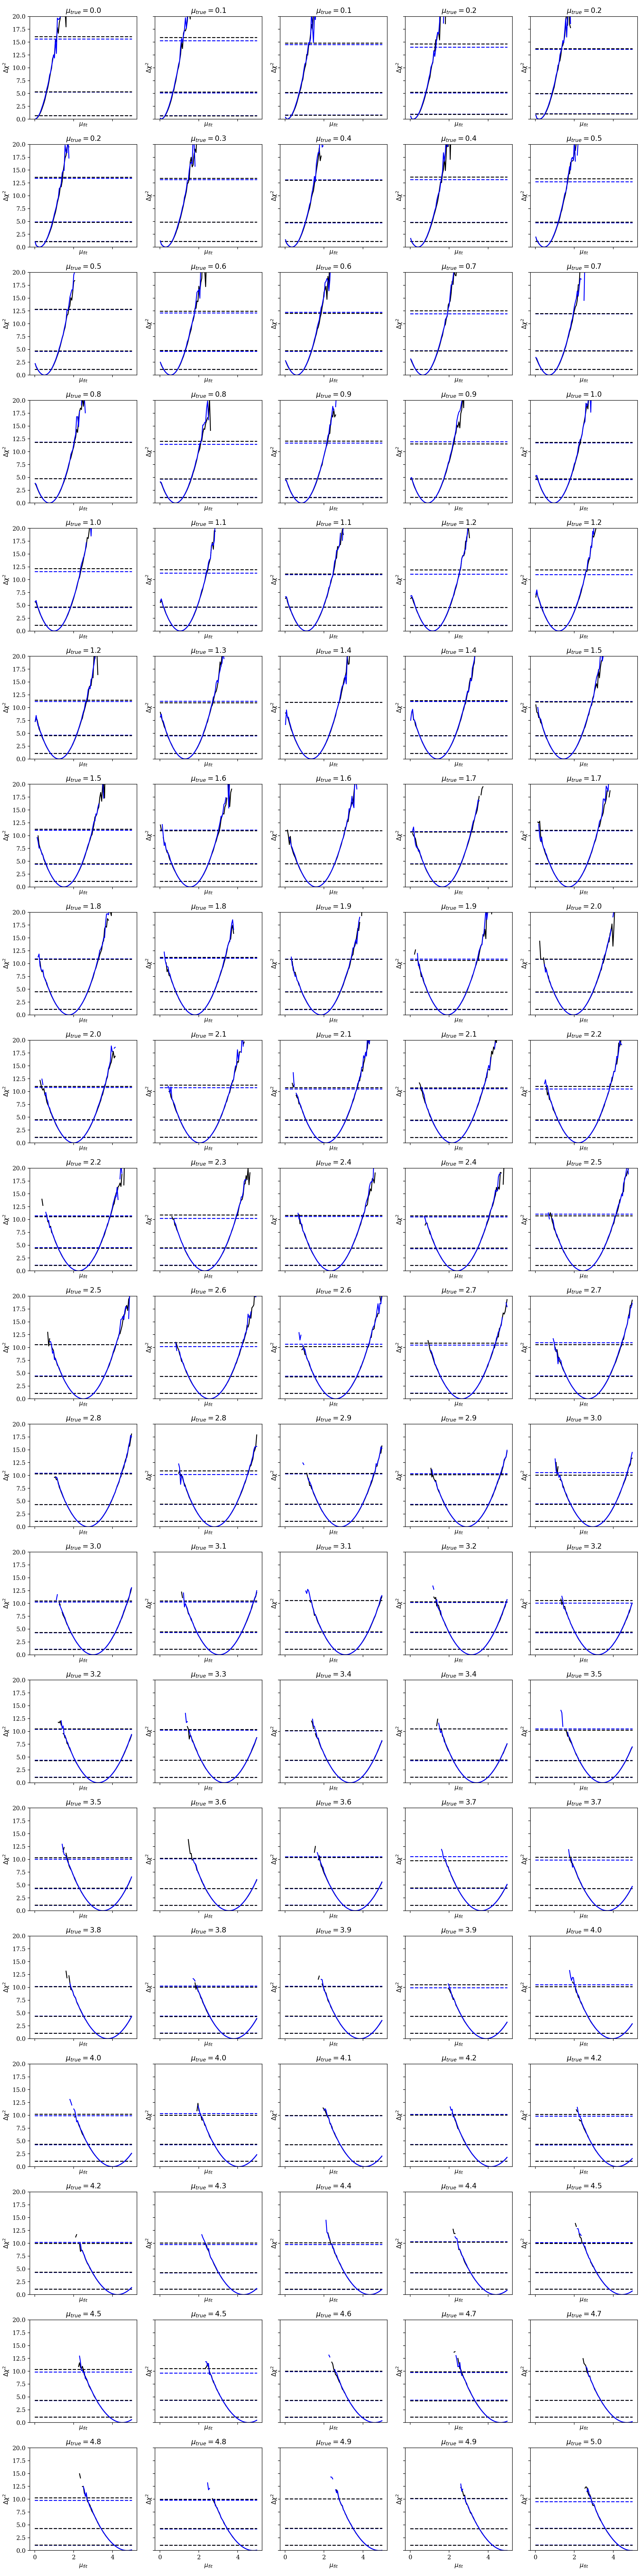

In [40]:
fig,ax = plt.subplots(int(len(TRUE_VALS)/5),5,sharex=True,sharey=True)
fig.set_size_inches(3*5, 3*int(len(TRUE_VALS)/5))

for itrue in range(len(TRUE_VALS)-1):
    iay=int(itrue/5)
    iax=itrue%5
    
    qstring = "abs(mu_true-%f)<0.001"%TRUE_VALS[itrue]

    res_tot = make_profile_bins(df_pes_tot.query(qstring),0,TRUE_VALS[-1],len(TRUE_VALS),"mu_fit","chi2_diff")
    res_cond = make_profile_bins(df_pes_cond.query(qstring),0,TRUE_VALS[-1],len(TRUE_VALS),"mu_fit","chi2_diff")
    #res_median = make_profile_bins(df_pes_tot.query(qstring),0,TRUE_VALS[-1],len(TRUE_VALS),"mu_fit","chi2_diff",func="median")


    ax[iay][iax].plot(res_tot["x"],res_tot["y"],color='k')
    ax[iay][iax].plot(res_cond["x"],res_cond["y"],color='b')
    #ax.plot(res_median["x"],res_median["median"],color='k',linestyle="-.")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_cond[0][itrue],color='blue',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_cond[1][itrue],color='blue',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_cond[2][itrue],color='blue',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_tot[0][itrue],color='k',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_tot[1][itrue],color='k',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_tot[2][itrue],color='k',linestyle="--",label="")
    #ax[iay][iax].set_ylim(bottom=0,top=critical_vals_cond[2][itrue]+10)

    #plt.legend()
    ax[iay][iax].set_ylabel("$\Delta\chi^2$")
    ax[iay][iax].set_xlabel("$\mu_{fit}$")
    ax[iay][iax].set_title("$\mu_{true}=%1.1f$"%TRUE_VALS[itrue])

plt.setp(ax, ylim=(0,20))
plt.tight_layout()
#plt.subplots_adjust(bottom=0.2,top=0.8)
plt.show()
plt.savefig(tmp_plot())

<IPython.core.display.Javascript object>


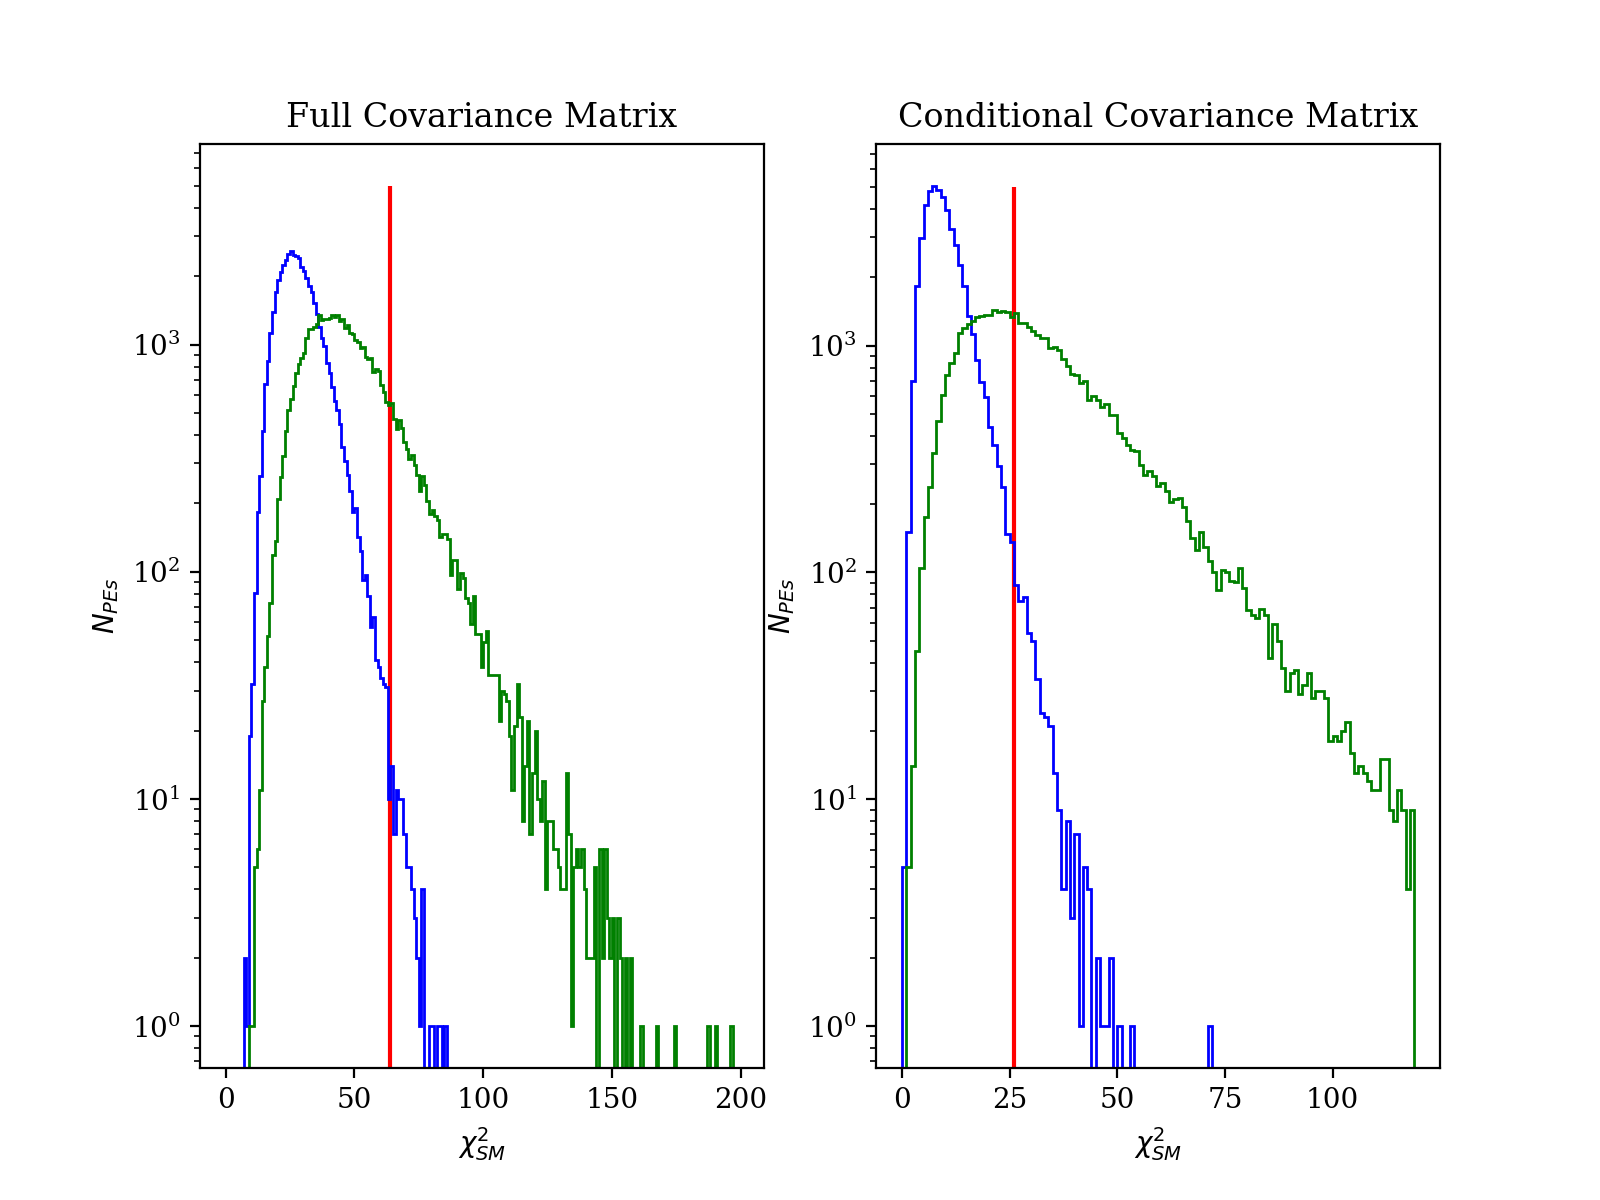

In [47]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8, 6)

bins=np.arange(0,200,1)

ax[0].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_h0"],bins=bins,label="$\mu_{true}=0.0$",histtype="step",log=True)
ax[0].hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_h0"],bins=bins,label="$\mu_{true}=1.0$",histtype="step",log=True)
ax[0].vlines(x=CHI2_SIG_FULL(0,DATA_OBS),ymin=0,ymax=5e3,color="r")

ax[0].set_xlabel("$\chi^2_{SM}$")
ax[0].set_ylabel("$N_{PEs}$")
ax[0].set_title("Full Covariance Matrix")

bins2=np.arange(0,120,1)

ax[1].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_h0"],bins=bins2,label="$\mu_{true}=0.0$",histtype="step",log=True)
ax[1].hist(df_pes_cond.query("abs(mu_true-1.0)<0.001")["chi2_h0"],bins=bins2,label="$\mu_{true}=1.0$",histtype="step",log=True)
ax[1].vlines(x=CHI2_SIG_COND(0,NUE_OBS),ymin=0,ymax=5e3,color="r")

ax[1].set_xlabel("$\chi^2_{SM}$")
ax[1].set_ylabel("$N_{PEs}$")
ax[1].set_title("Conditional Covariance Matrix")

plt.show()
plt.savefig(tmp_plot())

<IPython.core.display.Javascript object>


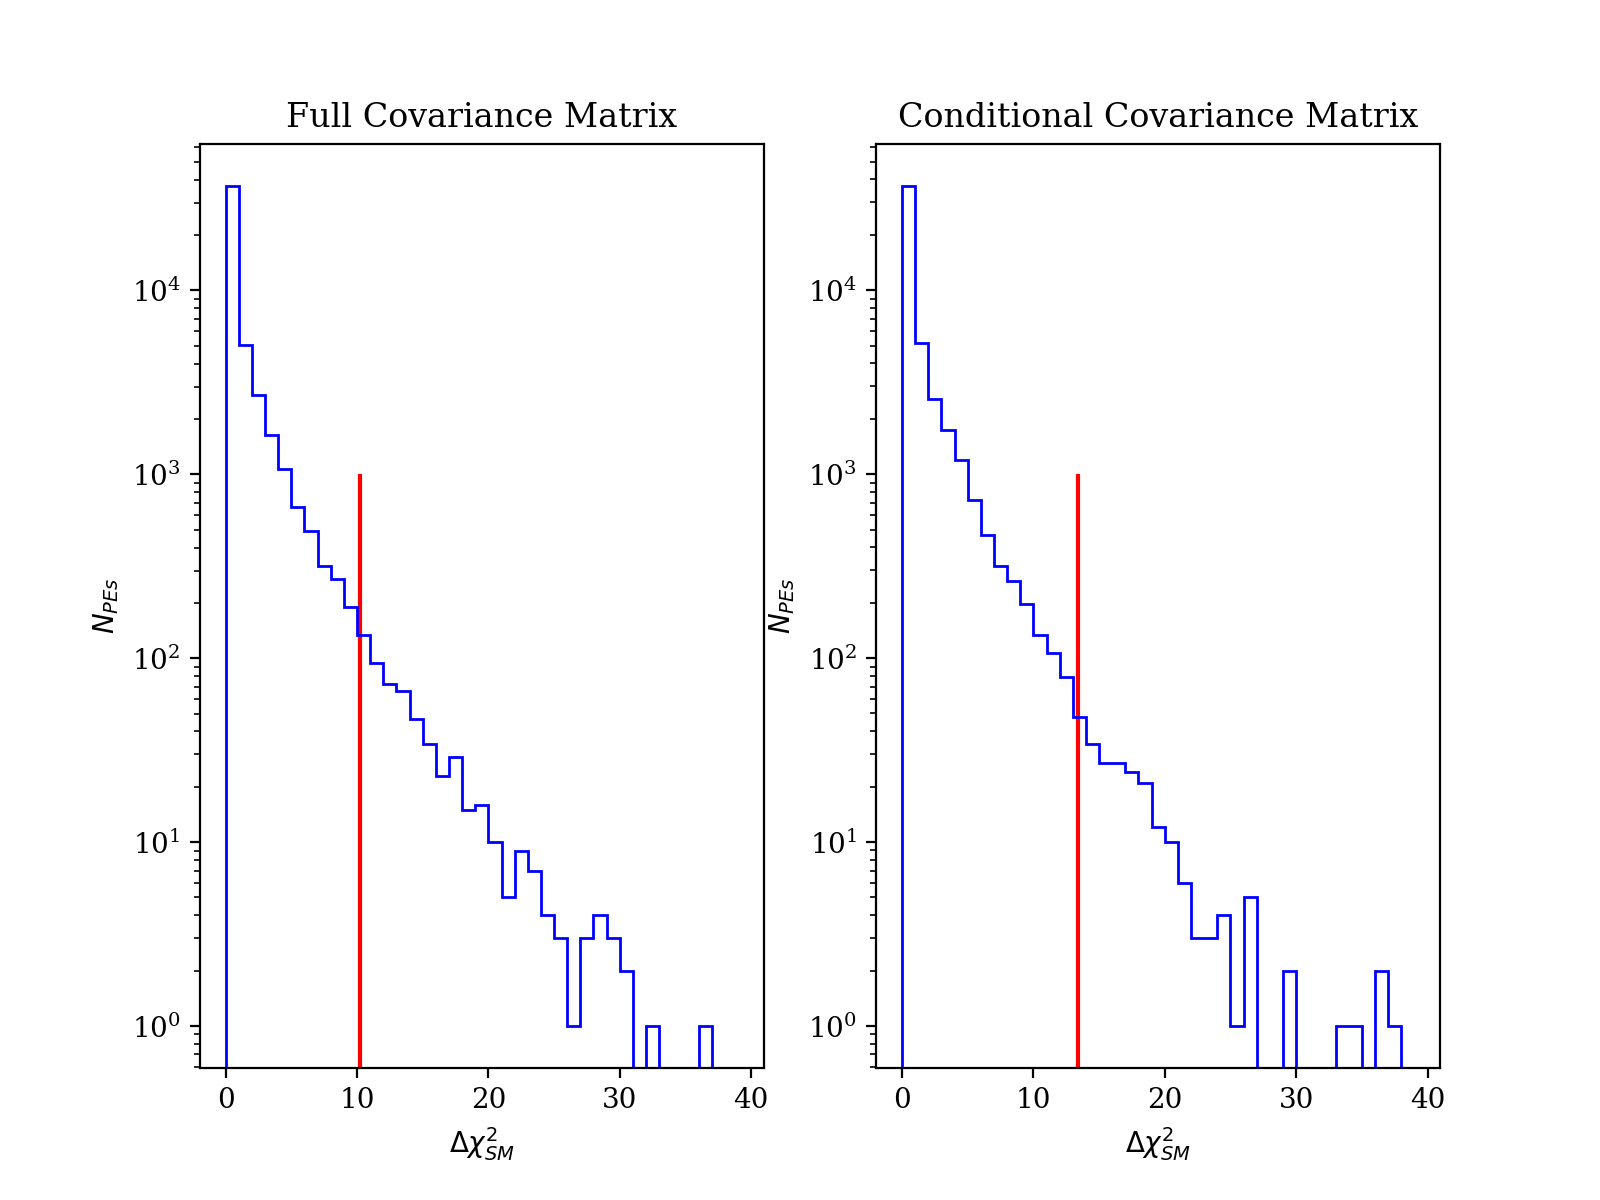

In [41]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8, 6)

bins=np.arange(0,40,1)

ax[0].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_diff"],bins=bins,label="$\mu_{true}=0.0$",histtype="step",log=True)
ax[0].vlines(x=CHI2_DIFF_FULL(DATA_OBS,[0]),ymin=0,ymax=1000,color="r")

ax[0].set_xlabel("$\Delta\chi^2_{SM}$")
ax[0].set_ylabel("$N_{PEs}$")
ax[0].set_title("Full Covariance Matrix")

bins2=np.arange(0,40,1)

ax[1].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_diff"],bins=bins2,label="$\mu_{true}=0.0$",histtype="step",log=True)
ax[1].vlines(x=CHI2_DIFF_COND(NUE_OBS,[0]),ymin=0,ymax=1000,color="r")

ax[1].set_xlabel("$\Delta\chi^2_{SM}$")
ax[1].set_ylabel("$N_{PEs}$")
ax[1].set_title("Conditional Covariance Matrix")

plt.show()
plt.savefig(tmp_plot())

In [222]:
def CALC_COND_CHI2(pe):
    nue_exp = COND_EXP(pe[10:]-NUMU_EXP,NUE_EXP,M_COV_NUMU_INV,M_COV_EM)
    return CHI2(pe[:10]-nue_exp,np.linalg.inv(M_COV_COND_SYS+np.diagflat(nue_exp)))
def CALC_COND_SIG_CHI2(pe,mu):
    nue_exp = COND_EXP(pe[10:]-NUMU_EXP,NUE_EXP,M_COV_NUMU_INV,M_COV_EM)+mu*SIG_EXP[:10]
    return CHI2(pe[:10]-nue_exp,np.linalg.inv(M_COV_COND_SYS+np.diagflat(nue_exp)))

def CALC_COND2_CHI2(pe):
    nue_exp = COND_EXP(pe[10:]-NUMU_EXP,NUE_EXP,M_COV_NUMU_INV,M_COV_EM)
    m_cov_cond_sys = COND_COV(M_COV_NUE_SYS,M_COV_NUMU_INV,M_COV_ME_SYS,M_COV_EM_SYS)
    return CHI2(pe[:10]-nue_exp,np.linalg.inv(m_cov_cond_sys+np.diagflat(nue_exp)))
def CALC_COND2_SIG_CHI2(pe,mu):
    nue_exp = COND_EXP(pe[10:]-NUMU_EXP,NUE_EXP,M_COV_NUMU_INV,M_COV_EM)+mu*SIG_EXP[:10]
    m_cov_cond_sys = COND_COV(M_COV_NUE_SYS,M_COV_NUMU_INV,M_COV_ME_SYS,M_COV_EM_SYS)
    return CHI2(pe[:10]-nue_exp,np.linalg.inv(m_cov_cond_sys+np.diagflat(nue_exp)))

In [179]:
CALC_COND_CHI2(DATA_OBS)-CALC_COND_SIG_CHI2(DATA_OBS,1.0)

12.905953681216857

In [53]:
df_pes_tot["chi2_cond"] = df_pes_tot["pe_data"].apply(lambda pe: CALC_COND_CHI2(pe))

In [223]:
df_pes_tot["chi2_cond2"] = df_pes_tot["pe_data"].apply(lambda pe: CALC_COND2_CHI2(pe))

In [163]:
df_pes_tot["chi2_cond_sig1"] = df_pes_tot["pe_data"].apply(lambda pe: CALC_COND_SIG_CHI2(pe,1.0))

In [224]:
df_pes_tot["chi2_cond2_sig1"] = df_pes_tot["pe_data"].apply(lambda pe: CALC_COND2_SIG_CHI2(pe,1.0))

In [84]:
df_pes_tot["chi2_numu"] = df_pes_tot["pe_data"].apply(lambda pe: CHI2(pe[10:]-NUMU_EXP,M_COV_NUMU_INV))

In [89]:
df_pes_tot["chi2_nue"] = df_pes_tot["pe_data"].apply(lambda pe: CHI2(pe[:10]-NUE_EXP,M_COV_NUE_INV))

In [90]:
df_pes_cond["chi2_nue"] = df_pes_cond["pe_data"].apply(lambda pe: CHI2(pe[:10]-NUE_EXP,M_COV_NUE_INV))

In [263]:
df_pes_tot_tmp = df_pes_tot.iloc[:10].copy()
df_pes_tot_tmp["mu_best_2"], df_pes_tot_tmp["chi2_h0_cond2"], df_pes_tot_tmp["chi2_h1_cond2"], df_pes_tot_tmp["chi2_best_2"] = zip(*df_pes_tot_tmp.apply(lambda x: FIT_PE_CALC_COND(x["pe_data"],x["mu_true"]), axis=1))

In [264]:
df_pes_tot_tmp

mu_true  chi2_h0  chi2_hs  chi2_h1  chi2_hb  chi2_diff    mu_fit  \
0.0      0.0   26.528  36.2698   26.528   26.528   0.000000  0.000000   
1.0      0.0   35.895  41.4735   35.895  35.7451   0.149820  0.099245   
2.0      0.0  34.5446  42.9376  34.5446  34.5446   0.000000  0.000000   
3.0      0.0  29.2739  29.5186  29.2739  27.1734   2.100428  0.393188   
4.0      0.0  21.8838  29.0496  21.8838  21.8838   0.000000  0.000000   
5.0      0.0   41.982  49.0499   41.982   41.982   0.000000  0.000000   
6.0      0.0  26.3743  33.3821  26.3743  26.3743   0.000000  0.000000   
7.0      0.0  29.2898  29.1728  29.2898  27.2116   2.078215  0.428511   
8.0      0.0  29.0103  36.4524  29.0103  29.0103   0.000000  0.000000   
9.0      0.0  37.8861   40.278  37.8861  37.2569   0.629268  0.260205   

                                               pe_data  chi2_cond  chi2_numu  \
0.0  [1, 2, 4, 7, 5, 6, 3, 4, 2, 1, 1, 44, 85, 129,...   4.406391  22.192989   
1.0  [1, 9, 4, 4, 6, 8, 7, 2, 3, 1, 0, 45, 98, 192,...   6.646079  28.384663   
2.0  [0, 3, 3, 6, 10, 6, 1, 9, 3, 2, 1, 41, 57, 91,...  13.549025  22.707860   
3.0  [2, 10, 6, 10, 7, 4, 6, 2, 4, 2, 1, 56, 102, 1...   7.113492  21.298359   
4.0  [0, 7, 2, 7, 6, 5, 7, 2, 1, 3, 1, 47, 80, 168,...   8.115175  13.605451   
5.0  [2, 4, 4, 5, 8, 11, 7, 10, 2, 4, 2, 29, 109, 1...  12.283574  29.593492   
6.0  [0, 6, 7, 3, 5, 7, 3, 3, 4, 3, 1, 45, 78, 160,...   4.980618  21.179584   
7.0  [0, 10, 6, 7, 8, 8, 4, 8, 2, 2, 0, 41, 79, 153...   6.784618  22.515575   
8.0  [1, 5, 5, 6, 8, 5, 10, 4, 0, 2, 1, 49, 96, 183...  10.728264  17.265928   
9.0  [0, 4, 10, 5, 5, 4, 5, 8, 1, 1, 0, 38, 70, 112...  11.567977  26.819133   

      chi2_nue  chi2_cond_sig1  chi2_cond2  chi2_cond2_sig1  mu_best_2  \
0.0   3.572045       14.336142    4.249610        13.803134   0.000000   
1.0   7.064176       12.210846    6.544795        11.891288   0.039474   
2.0  11.039648       22.222529   13.322174        21.765277   0.000000   
3.0   9.614044        7.599992    6.930206         7.419927   0.359185   
4.0   7.900644       15.468408    7.931624        15.036780   0.000000   
5.0  12.352085       19.416964   11.980504        18.956021   0.000000   
6.0   4.727993       12.161141    4.916491        11.809588   0.000000   
7.0   6.872494        6.686912    6.632321         6.538802   0.197982   
8.0  11.419438       18.173499   10.698118        17.881987   0.000000   
9.0  11.385857       14.303973   11.472631        13.968826   0.000000   

     chi2_h0_cond2  chi2_h1_cond2  chi2_best_2  
0.0       4.248526       4.248526     4.248526  
1.0       6.569193       6.569193     6.549992  
2.0      13.337316      13.337316    13.337316  
3.0       6.913115       6.913115     5.442979  
4.0       7.927173       7.927173     7.927173  
5.0      11.979227      11.979227    11.979227  
6.0       4.916528       4.916528     4.916528  
7.0       6.640664       6.640664     6.059476  
8.0      10.697023      10.697023    10.697023  
9.0      11.481644      11.481644    11.481644

<IPython.core.display.Javascript object>


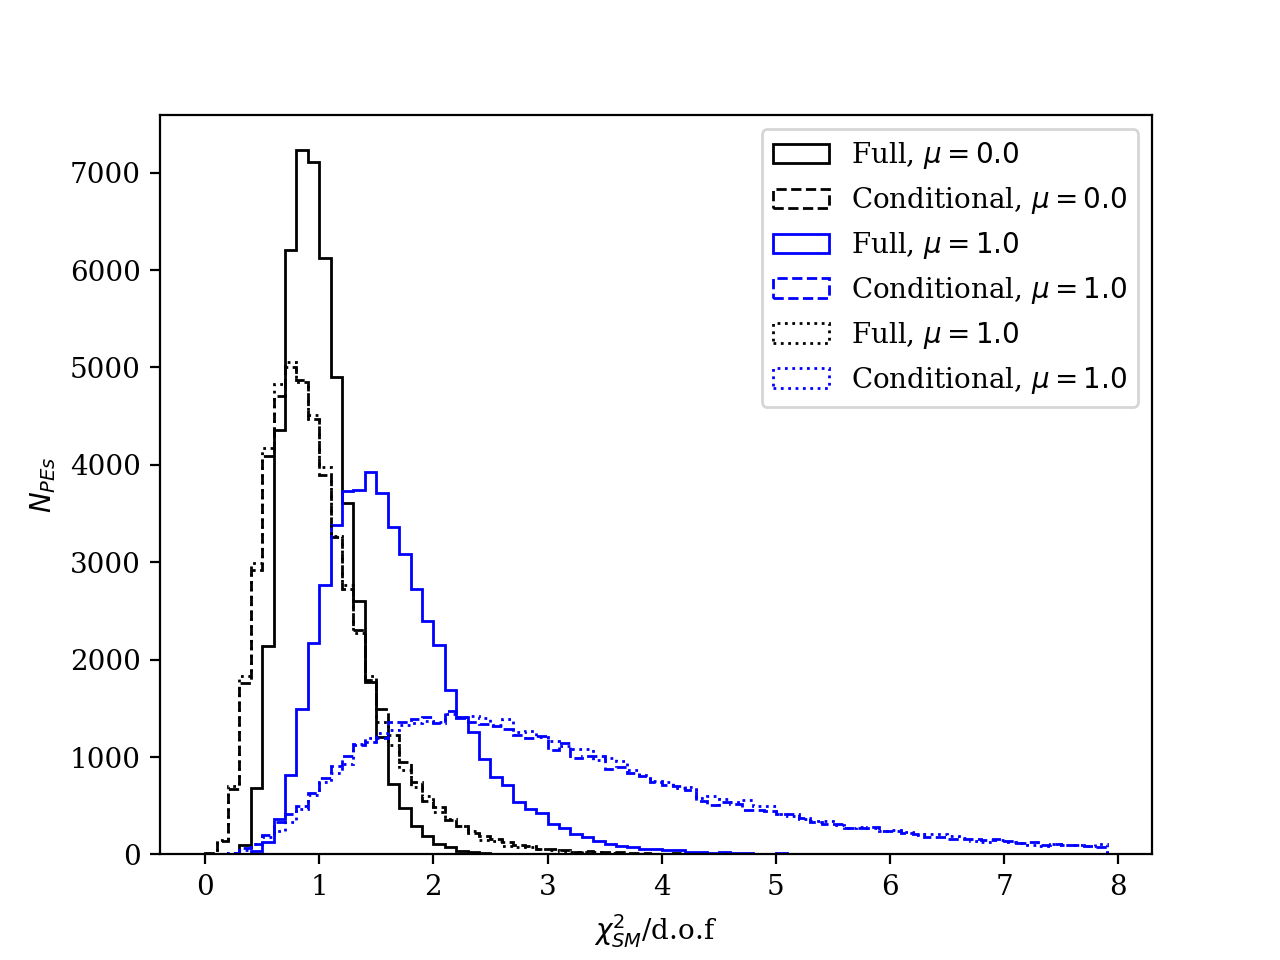

In [81]:
fig,ax = plt.subplots(1,1)

bins=np.arange(0,8,0.1)

ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_h0"]/len(DATA_EXP),bins=bins,label="Full, $\mu=0.0$",histtype="step",color='k')
ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond"]/len(NUE_EXP),bins=bins,label="Conditional, $\mu=0.0$",histtype="step",color='k',linestyle="--")
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_h0"]/len(DATA_EXP),bins=bins,label="Full, $\mu=1.0$",histtype="step",color='b')
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_cond"]/len(NUE_EXP),bins=bins,label="Conditional, $\mu=1.0$",histtype="step",color='b',linestyle="--")
ax.hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_h0"]/len(NUE_EXP),bins=bins,label="Full, $\mu=1.0$",histtype="step",color='k',linestyle="dotted")
ax.hist(df_pes_cond.query("abs(mu_true-1.0)<0.001")["chi2_h0"]/len(NUE_EXP),bins=bins,label="Conditional, $\mu=1.0$",histtype="step",color='b',linestyle="dotted")
#ax[0].vlines(x=CHI2_DIFF_FULL(DATA_OBS,[0]),ymin=0,ymax=1000,color="r")

ax.set_xlabel("$\chi^2_{SM}$/d.o.f")
ax.set_ylabel("$N_{PEs}$")

#ax[0].set_title("Full Covariance Matrix")
plt.legend()
plt.show()
plt.savefig(tmp_plot())

<IPython.core.display.Javascript object>


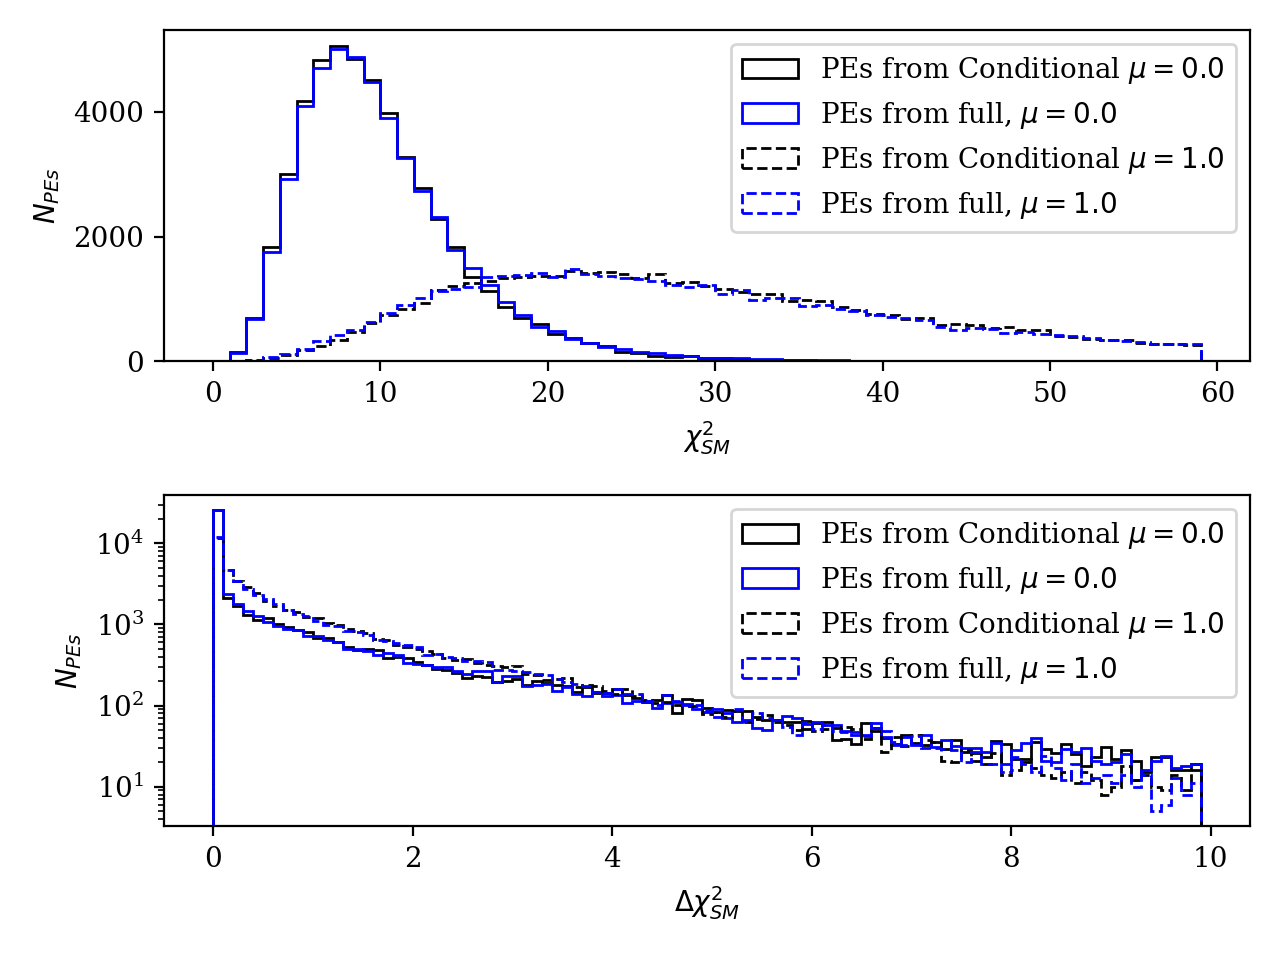

In [80]:
fig,ax = plt.subplots(2)

bins=np.arange(0,60,1)

ax[0].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_h0"],bins=bins,label="PEs from Conditional $\mu=0.0$",histtype="step",color='k')
ax[0].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond"],bins=bins,label="PEs from full, $\mu=0.0$",histtype="step",color='b')
ax[0].hist(df_pes_cond.query("abs(mu_true-1.0)<0.001")["chi2_h0"],bins=bins,label="PEs from Conditional $\mu=1.0$",histtype="step",color='k',linestyle="--")
ax[0].hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_cond"],bins=bins,label="PEs from full, $\mu=1.0$",histtype="step",color='b',linestyle="--")
#ax[0].vlines(x=CHI2_DIFF_FULL(DATA_OBS,[0]),ymin=0,ymax=1000,color="r")

ax[0].set_xlabel("$\chi^2_{SM}$")
ax[0].set_ylabel("$N_{PEs}$")
ax[0].legend()

bins2=np.arange(0,10,0.1)

ax[1].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_diff"],bins=bins2,label="PEs from Conditional $\mu=0.0$",histtype="step",color='k')
ax[1].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_diff"],bins=bins2,label="PEs from full, $\mu=0.0$",histtype="step",color='b')
ax[1].hist(df_pes_cond.query("abs(mu_true-1.0)<0.001")["chi2_diff"],bins=bins2,label="PEs from Conditional $\mu=1.0$",histtype="step",color='k',linestyle="--",log=True)
ax[1].hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_diff"],bins=bins2,label="PEs from full, $\mu=1.0$",histtype="step",color='b',linestyle="--",log=True)

ax[1].set_xlabel("$\Delta\chi^2_{SM}$")
ax[1].set_ylabel("$N_{PEs}$")


#ax[0].set_title("Full Covariance Matrix")
ax[1].legend()
plt.tight_layout()
plt.show()
plt.savefig(tmp_plot())

<IPython.core.display.Javascript object>


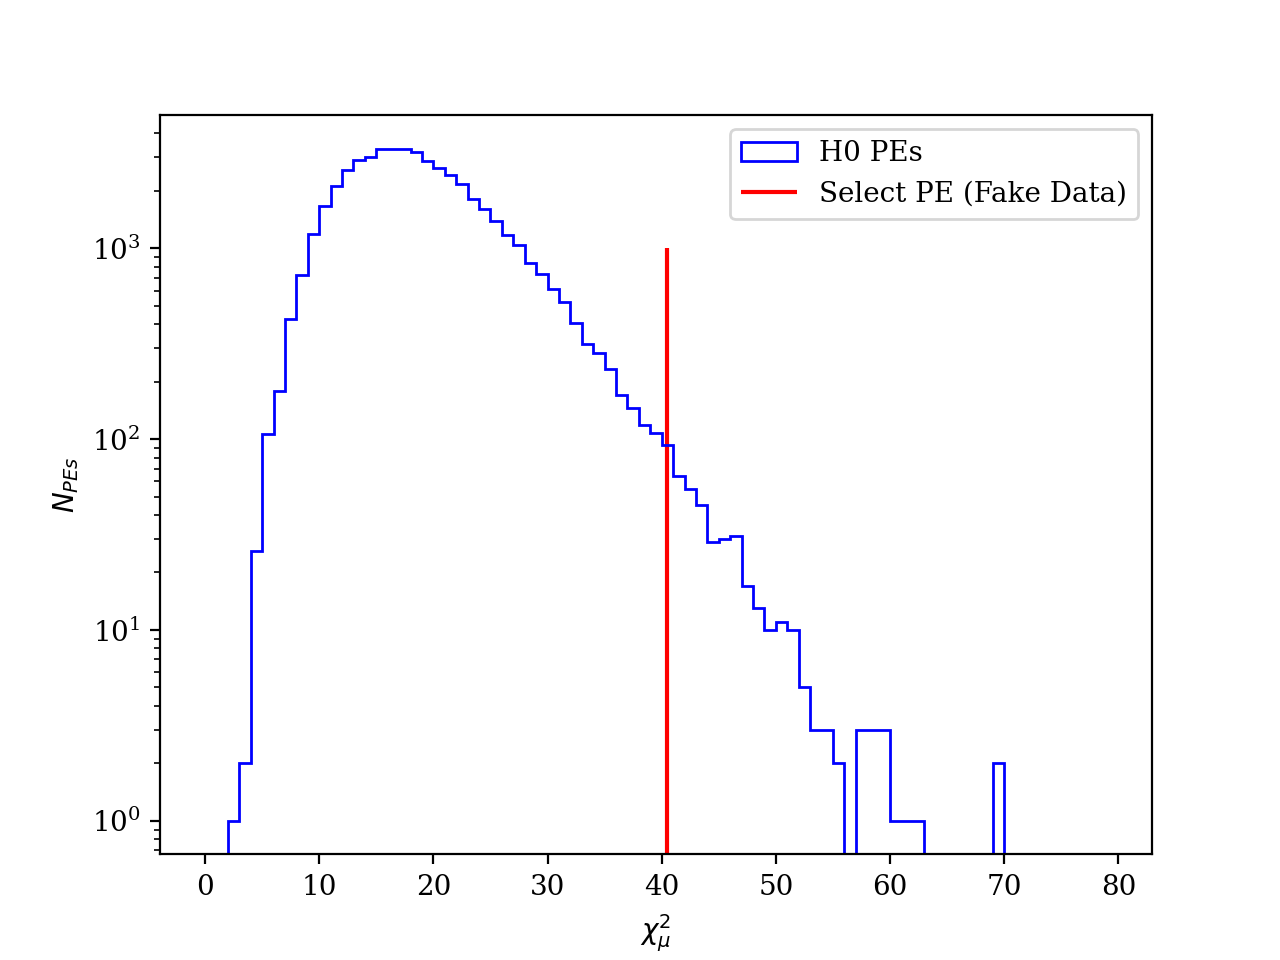

In [106]:
fig,ax = plt.subplots()

bins=np.arange(0,80,1)

ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_numu"],bins=bins,label="H0 PEs",histtype="step",log=True)
ax.vlines(x=CHI2(NUMU_OBS-NUMU_EXP,M_COV_NUMU_INV),ymin=0,ymax=1000,color="r",label="Select PE (Fake Data)")

ax.set_xlabel("$\chi^2_{\mu}$")
ax.set_ylabel("$N_{PEs}$")
ax.legend()

plt.show()
plt.savefig(tmp_plot(ftype="png"))

In [175]:
print(NUMU_OBS)
print(NUMU_EXP)
print((NUMU_OBS-NUMU_EXP)/NUMU_EXP)
print(CHI2(NUMU_OBS[1:]-NUMU_EXP[1:],np.linalg.inv(M_COV_NUMU[1:,1:])))
#print(M_COV_NUMU_SYS)

chi2_sum=0
for i in range(len(NUMU_OBS)):
    chi2_sum += (NUMU_OBS[i]-NUMU_EXP[i])*(NUMU_OBS[i]-NUMU_EXP[i])/np.sqrt(M_COV_NUMU[i][i])
print(chi2_sum)

[  5.  41.  85. 168. 168. 230. 250. 259. 184. 171. 181. 127. 111.  98.
  99.  70.  51.  41.  40.]
[  0.97314376  37.38443988  80.53931249 142.17343352 145.04233853
 202.35919399 216.6416141  192.61179874 168.18682688 157.63053179
 151.76532236 134.11335586 118.11208506  97.62313092  70.78867279
  53.80732227  42.26102513  40.22557237  37.52254905]
[ 4.13798701e+00  9.67129677e-02  5.53852196e-02  1.81655362e-01
  1.58282483e-01  1.36592786e-01  1.53979585e-01  3.44673596e-01
  9.40214725e-02  8.48152198e-02  1.92630814e-01 -5.30398767e-02
 -6.02147109e-02  3.86044863e-03  3.98528834e-01  3.00938182e-01
  2.06785681e-01  1.92521221e-02  6.60256569e-02]
26.656643717572763
396.7478412801523


<IPython.core.display.Javascript object>


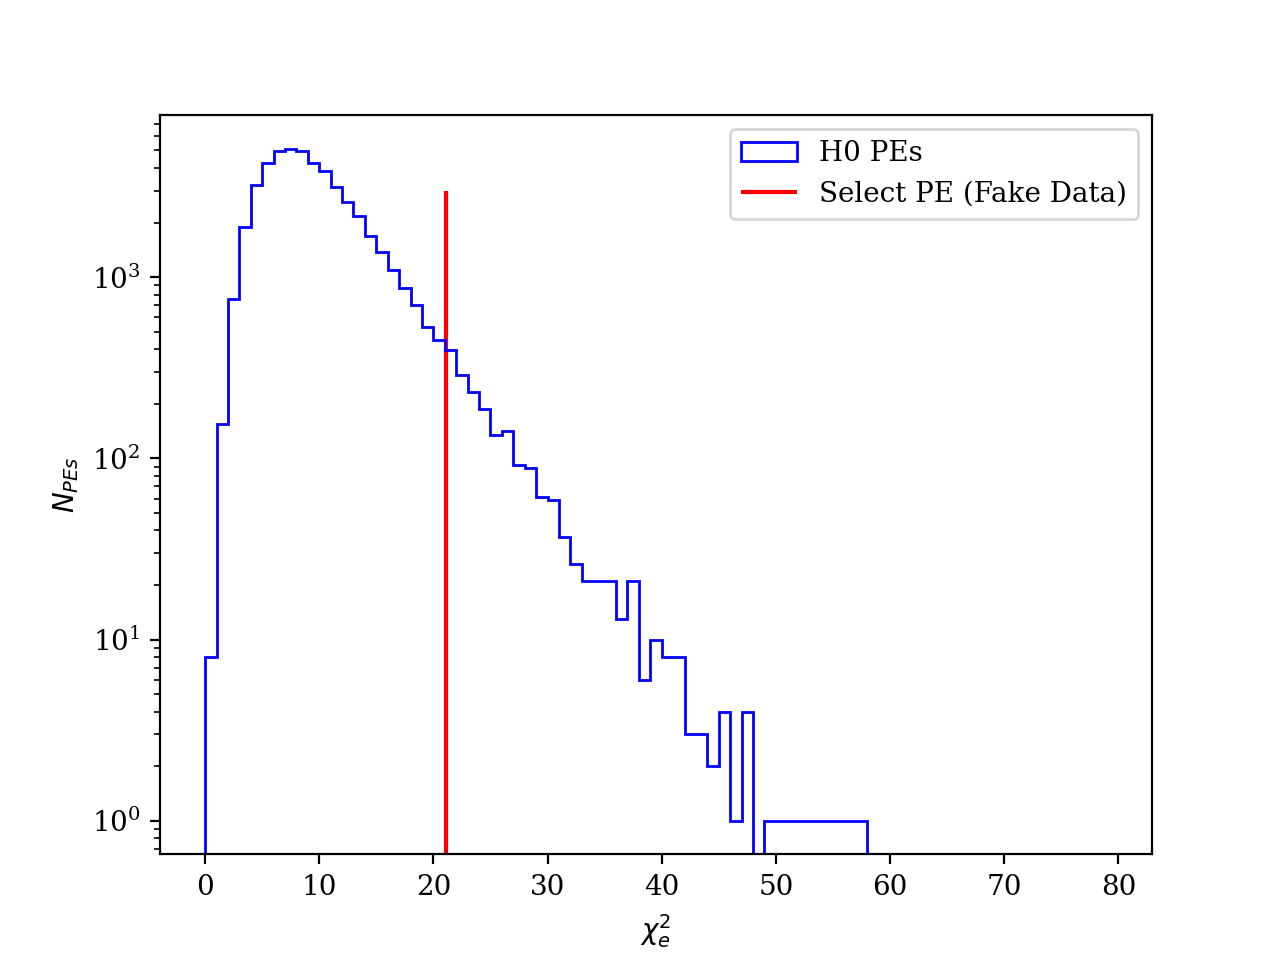

In [108]:
fig,ax = plt.subplots()

bins=np.arange(0,40,1)

ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_nue"],bins=bins,label="Full PEs, Original $\chi^2$",color='b',histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond"],bins=bins,label="Full PEs, Conditional $\chi^2$",color='b',histtype="step",log=True,linestyle="dashed")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP,M_COV_NUE_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Original $\chi^2$")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Conditional $\chi^2$",linestyle="dashed")

ax.set_xlabel("$\chi^2_{e}$")
ax.set_ylabel("$N_{PEs}$")
ax.legend()

plt.show()
plt.savefig(tmp_plot(ftype="png"))

<IPython.core.display.Javascript object>


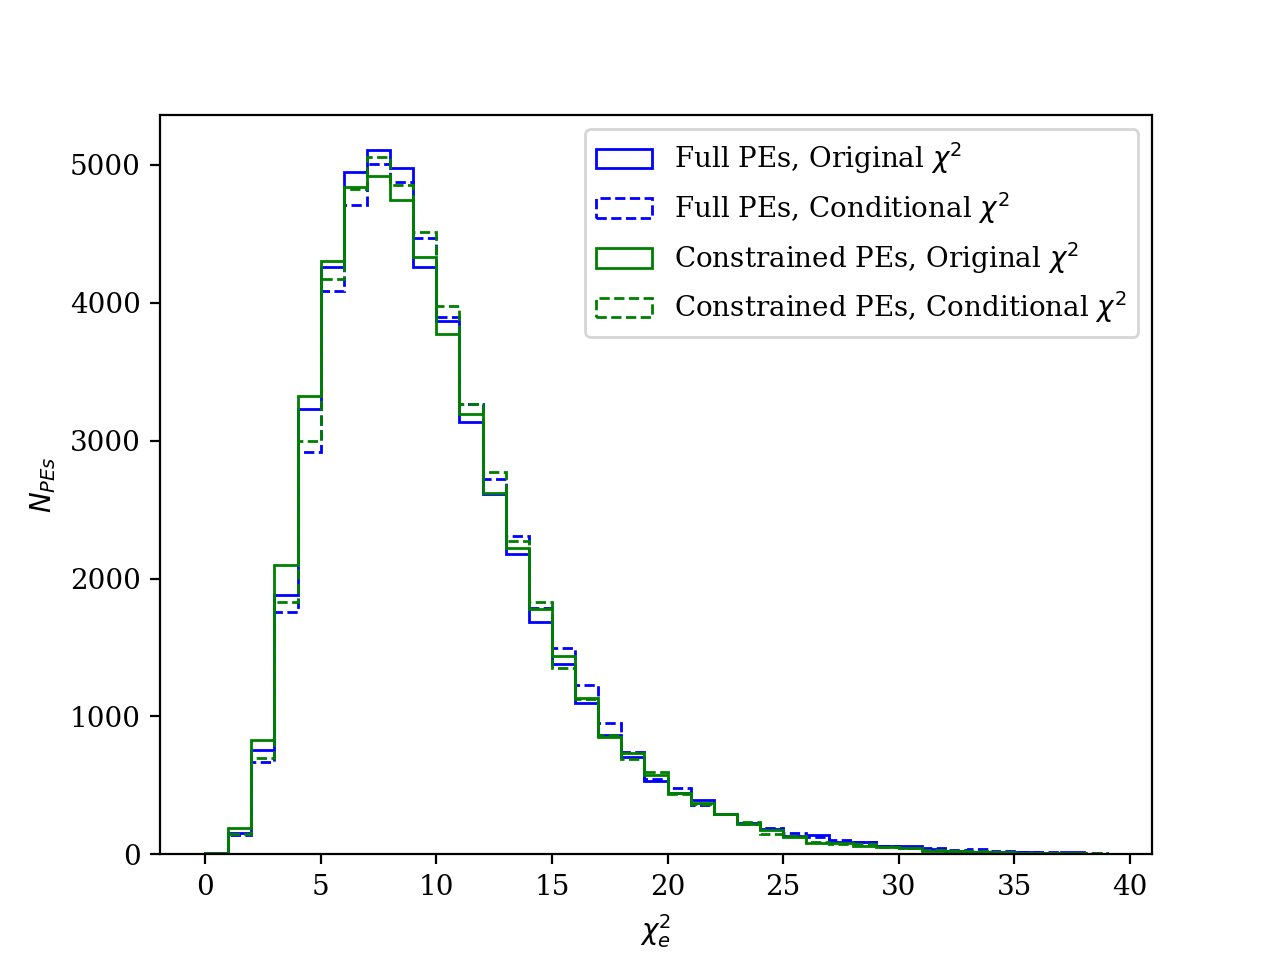

In [116]:
fig,ax = plt.subplots()

bins=np.arange(0,40,1)

ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_nue"],bins=bins,label="Full PEs, Original $\chi^2$",color='b',histtype="step")
ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond"],bins=bins,label="Full PEs, Conditional $\chi^2$",color='b',histtype="step",linestyle="dashed")
ax.hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_nue"],bins=bins,label="Constrained PEs, Original $\chi^2$",color='g',histtype="step")
ax.hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_h0"],bins=bins,label="Constrained PEs, Conditional $\chi^2$",color='g',histtype="step",linestyle="dashed")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP,M_COV_NUE_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Original $\chi^2$")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Conditional $\chi^2$",linestyle="dashed")

ax.set_xlabel("$\chi^2_{e}$")
ax.set_ylabel("$N_{PEs}$")
ax.legend()

plt.show()
plt.savefig(tmp_plot(ftype="png"))

<IPython.core.display.Javascript object>


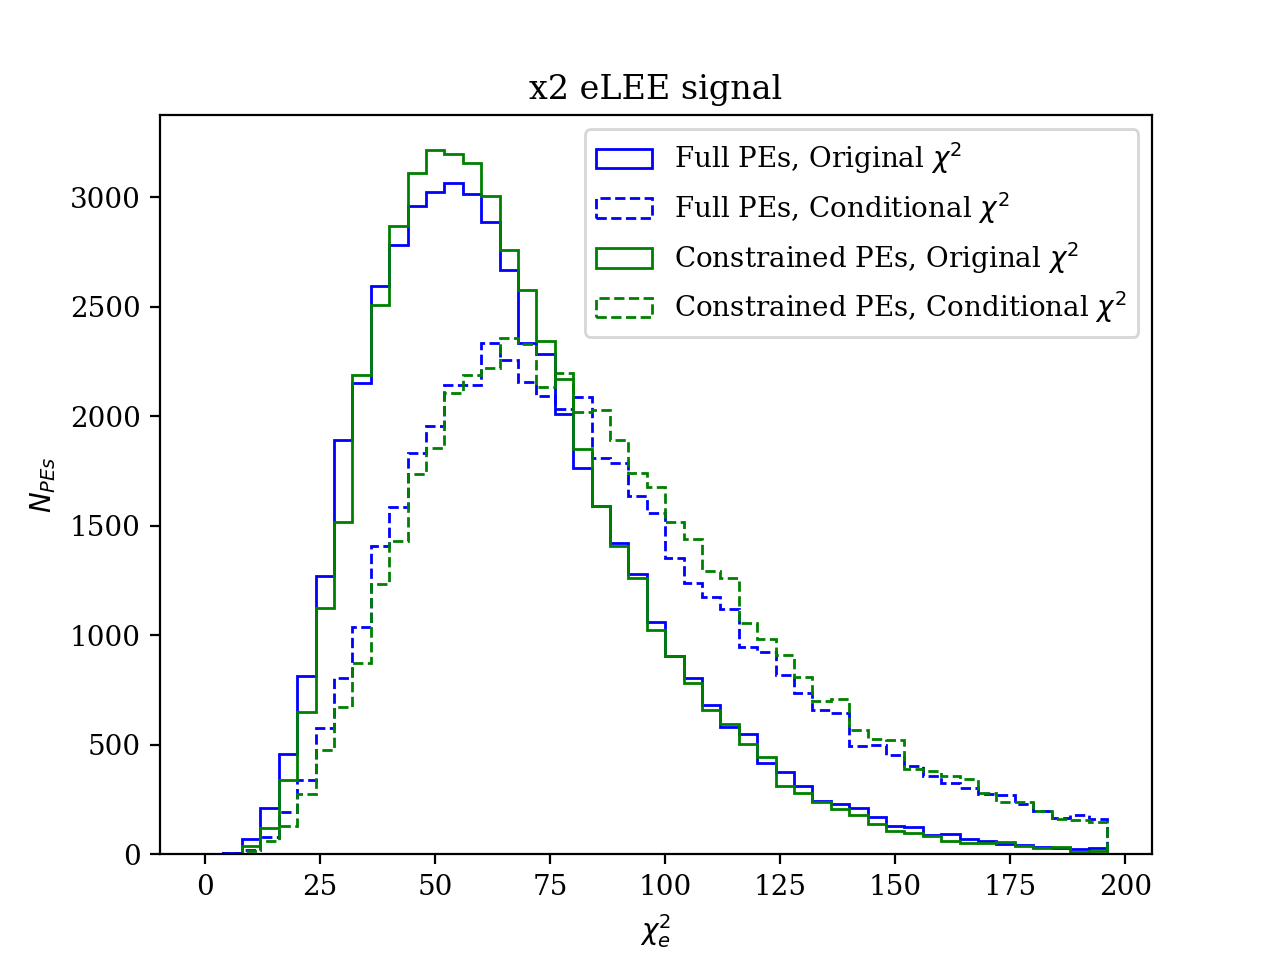

In [120]:
fig,ax = plt.subplots()

bins=np.arange(0,200,4)

ax.hist(df_pes_tot.query("abs(mu_true-2.0)<0.001")["chi2_nue"],bins=bins,label="Full PEs, Original $\chi^2$",color='b',histtype="step")
ax.hist(df_pes_tot.query("abs(mu_true-2.0)<0.001")["chi2_cond"],bins=bins,label="Full PEs, Conditional $\chi^2$",color='b',histtype="step",linestyle="dashed")
ax.hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_nue"],bins=bins,label="Constrained PEs, Original $\chi^2$",color='g',histtype="step")
ax.hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_h0"],bins=bins,label="Constrained PEs, Conditional $\chi^2$",color='g',histtype="step",linestyle="dashed")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP,M_COV_NUE_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Original $\chi^2$")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Conditional $\chi^2$",linestyle="dashed")

ax.set_xlabel("$\chi^2_{e}$")
ax.set_ylabel("$N_{PEs}$")
ax.legend()

plt.title("x2 eLEE signal")
plt.show()
plt.savefig(tmp_plot(ftype="png"))

In [228]:
df_pes_tot_diff0s = df_pes_tot[["mu_true","chi2_h0","chi2_hs","chi2_cond","chi2_cond_sig1","chi2_cond2","chi2_cond2_sig1"]]
df_pes_tot_diff0s["chi2_diff0s"]=df_pes_tot_diff0s["chi2_h0"]-df_pes_tot_diff0s["chi2_hs"]
df_pes_tot_diff0s["chi2_cond_diff0s"]=df_pes_tot_diff0s["chi2_cond"]-df_pes_tot_diff0s["chi2_cond_sig1"]
df_pes_tot_diff0s["chi2_cond2_diff0s"]=df_pes_tot_diff0s["chi2_cond2"]-df_pes_tot_diff0s["chi2_cond2_sig1"]

df_pes_cond_diff0s = df_pes_cond[["mu_true","chi2_h0","chi2_hs"]]
df_pes_cond_diff0s["chi2_diff0s"]=df_pes_cond_diff0s["chi2_h0"]-df_pes_cond_diff0s["chi2_hs"]

fd_chi2_diff0s = CHI2(DATA_OBS-DATA_EXP,M_COV_INV)-CHI2_SIG_FULL(1.0,DATA_OBS)
fd_chi2_cond_diff0s = CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND_INV)-CHI2_SIG_COND(1.0,NUE_OBS)
fd_chi2_cond2_diff0s = CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND2_INV)-CALC_COND2_SIG_CHI2(DATA_OBS,1.0)

n_chi2_h0_diff0s = df_pes_tot_diff0s.query("abs(mu_true-0.0)<0.001 and chi2_diff0s>%f"%fd_chi2_diff0s)["mu_true"].count()
n_chi2_cond_h0_diff0s_fullpe = df_pes_tot_diff0s.query("abs(mu_true-0.0)<0.001 and chi2_cond_diff0s>%f"%fd_chi2_cond_diff0s)["mu_true"].count()
n_chi2_cond2_h0_diff0s_fullpe = df_pes_tot_diff0s.query("abs(mu_true-0.0)<0.001 and chi2_cond2_diff0s>%f"%fd_chi2_cond2_diff0s)["mu_true"].count()
n_chi2_cond_h0_diff0s_condpe = df_pes_cond_diff0s.query("abs(mu_true-0.0)<0.001 and chi2_diff0s>%f"%fd_chi2_cond_diff0s)["mu_true"].count()

print(n_chi2_h0_diff0s,n_chi2_cond_h0_diff0s_fullpe,n_chi2_cond2_h0_diff0s_fullpe,n_chi2_cond_h0_diff0s_condpe)
print(n_chi2_h0_diff0s/5e4,n_chi2_cond_h0_diff0s_fullpe/5e4,n_chi2_cond2_h0_diff0s_fullpe/5e4,n_chi2_cond_h0_diff0s_condpe/5e4)

<ipython-input-228-8e200b8079bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pes_tot_diff0s["chi2_diff0s"]=df_pes_tot_diff0s["chi2_h0"]-df_pes_tot_diff0s["chi2_hs"]
<ipython-input-228-8e200b8079bf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pes_tot_diff0s["chi2_cond_diff0s"]=df_pes_tot_diff0s["chi2_cond"]-df_pes_tot_diff0s["chi2_cond_sig1"]
<ipython-input-228-8e200b8079bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

579 355 382 224
0.01158 0.0071 0.00764 0.00448


In [287]:
df_pes_cond_diff0s = df_pes_cond[["mu_true","chi2_h0","chi2_hs"]]
df_pes_cond_diff0s["chi2_diff0s"]=df_pes_cond_diff0s["chi2_h0"]-df_pes_cond_diff0s["chi2_hs"]
fd_chi2_cond_diff0s = CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND2_INV)-CALC_COND2_SIG_CHI2(DATA_OBS,1.0)
n_chi2_cond_h0_diff0s_condpe = df_pes_cond_diff0s.query("abs(mu_true-0.0)<0.001 and chi2_diff0s>%f"%fd_chi2_cond_diff0s)["mu_true"].count()


<ipython-input-287-efb4ea1f1a1e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pes_cond_diff0s["chi2_diff0s"]=df_pes_cond_diff0s["chi2_h0"]-df_pes_cond_diff0s["chi2_hs"]


In [221]:
CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND2_INV)
#print(NUE_OBS)

24.6243332669884

<IPython.core.display.Javascript object>


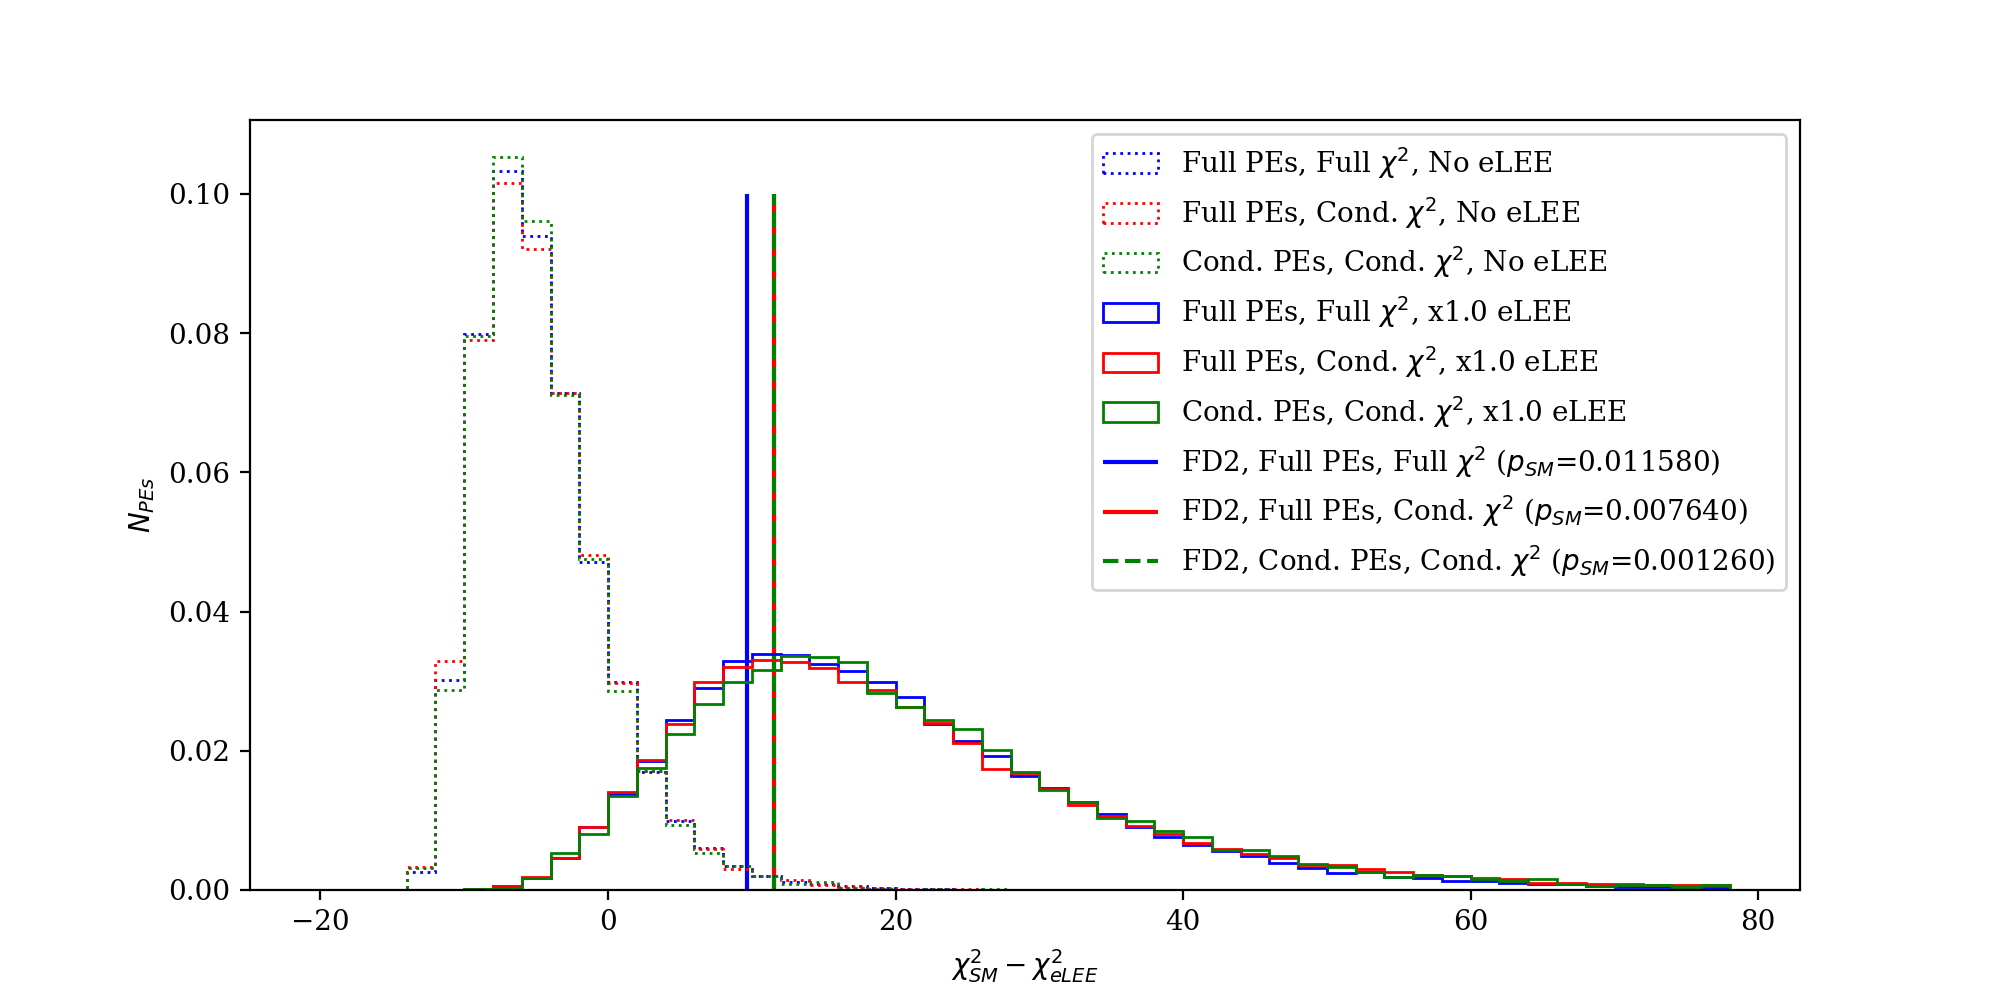

In [288]:
fig,ax = plt.subplots()
fig.set_size_inches(10,5)
bins=np.arange(-20,80,2)

df_pes_cond["mu_true"] = df_pes_cond["mu_true"].astype("float")

ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_h0"]-df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_hs"],bins=bins,label="Full PEs, Full $\chi^2$, No eLEE",color='b',histtype="step",linestyle="dotted",density=True)
ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond2"]-df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond2_sig1"],bins=bins,label="Full PEs, Cond. $\chi^2$, No eLEE",color='r',histtype="step",linestyle="dotted",density=True)
ax.hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_h0"]-df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_hs"],bins=bins,label="Cond. PEs, Cond. $\chi^2$, No eLEE",color='g',histtype="step",linestyle="dotted",density=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_h0"]-df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_hs"],bins=bins,label="Full PEs, Full $\chi^2$, x1.0 eLEE",color='b',histtype="step",density=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_cond2"]-df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_cond2_sig1"],bins=bins,label="Full PEs, Cond. $\chi^2$, x1.0 eLEE",color='r',histtype="step",density=True)
ax.hist(df_pes_cond.query("abs(mu_true-1.0)<0.001")["chi2_h0"]-df_pes_cond.query("abs(mu_true-1.0)<0.001")["chi2_hs"],bins=bins,label="Cond. PEs, Cond. $\chi^2$, x1.0 eLEE",color='g',histtype="step",density=True)



ax.vlines(x=(CHI2(DATA_OBS-DATA_EXP,M_COV_INV)-CHI2_SIG_FULL(1.0,DATA_OBS)),ymin=0,ymax=0.1,color="b",label="FD2, Full PEs, Full $\chi^2$ ($p_{SM}$=%f)"%(n_chi2_h0_diff0s/5e4))
ax.vlines(x=fd_chi2_cond2_diff0s,ymin=0,ymax=0.1,color="r",label="FD2, Full PEs, Cond. $\chi^2$ ($p_{SM}$=%f)"%(n_chi2_cond2_h0_diff0s_fullpe/5e4))
ax.vlines(x=fd_chi2_cond_diff0s,ymin=0,ymax=0.1,color="g",linestyle="--",label="FD2, Cond. PEs, Cond. $\chi^2$ ($p_{SM}$=%f)"%(n_chi2_cond_h0_diff0s_condpe/5e4))

#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Conditional $\chi^2$",linestyle="dashed")

ax.set_xlabel("$\chi^2_{SM} - \chi^2_{eLEE}$")
ax.set_ylabel("$N_{PEs}$")
ax.legend()

#plt.title("x2 eLEE signal")
plt.show()
plt.savefig(tmp_plot(ftype="png"))

In [209]:
df_pes_tot_diff0s["chi2_diff0s_diff"] = df_pes_tot_diff0s["chi2_diff0s"] - df_pes_tot_diff0s["chi2_cond_diff0s"]
df_pes_tot_diff0s["chi2_diff0s_diff"] = df_pes_tot_diff0s["chi2_diff0s_diff"].astype("float")
df_pes_tot_diff0s.query("abs(mu_true-0.0)<0.001 and abs(chi2_diff0s_diff)>5")

<ipython-input-209-1393cd5b5782>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pes_tot_diff0s["chi2_diff0s_diff"] = df_pes_tot_diff0s["chi2_diff0s"] - df_pes_tot_diff0s["chi2_cond_diff0s"]
<ipython-input-209-1393cd5b5782>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pes_tot_diff0s["chi2_diff0s_diff"] = df_pes_tot_diff0s["chi2_diff0s_diff"].astype("float")


mu_true  chi2_h0  chi2_hs  chi2_cond  chi2_cond_sig1 chi2_diff0s  \
170.0        0.0  58.1779  37.5676  33.228679       20.143923     20.6103   
1218.0       0.0  49.9057  34.2438  22.465868       12.437917     15.6619   
1262.0       0.0   44.886  27.3776  23.792928       11.658298     17.5084   
1274.0       0.0  33.3226  28.6869  28.777894       12.321350     4.63576   
1275.0       0.0  51.5669  27.0246  26.537055       10.415356     24.5423   
...          ...      ...      ...        ...             ...         ...   
48907.0      0.0  24.2887  24.5831  21.077677       13.134610   -0.294395   
49234.0      0.0  42.5706  33.4006  31.993951       15.794182     9.16997   
49396.0      0.0  39.7666  28.8951  34.735765       17.178047     10.8714   
49691.0      0.0  21.2557  20.2672  12.425799        5.578139    0.988453   
49989.0      0.0  25.4044  17.3529  22.133804        8.882205     8.05152   

         chi2_cond_diff0s  chi2_diff0s_diff  
170.0           13.084756          7.525516  
1218.0          10.027951          5.633923  
1262.0          12.134630          5.373779  
1274.0          16.456544        -11.820781  
1275.0          16.121699          8.420629  
...                   ...               ...  
48907.0          7.943068         -8.237463  
49234.0         16.199768         -7.029794  
49396.0         17.557718         -6.686294  
49691.0          6.847660         -5.859208  
49989.0         13.251599         -5.200080  

[302 rows x 8 columns]

<IPython.core.display.Javascript object>


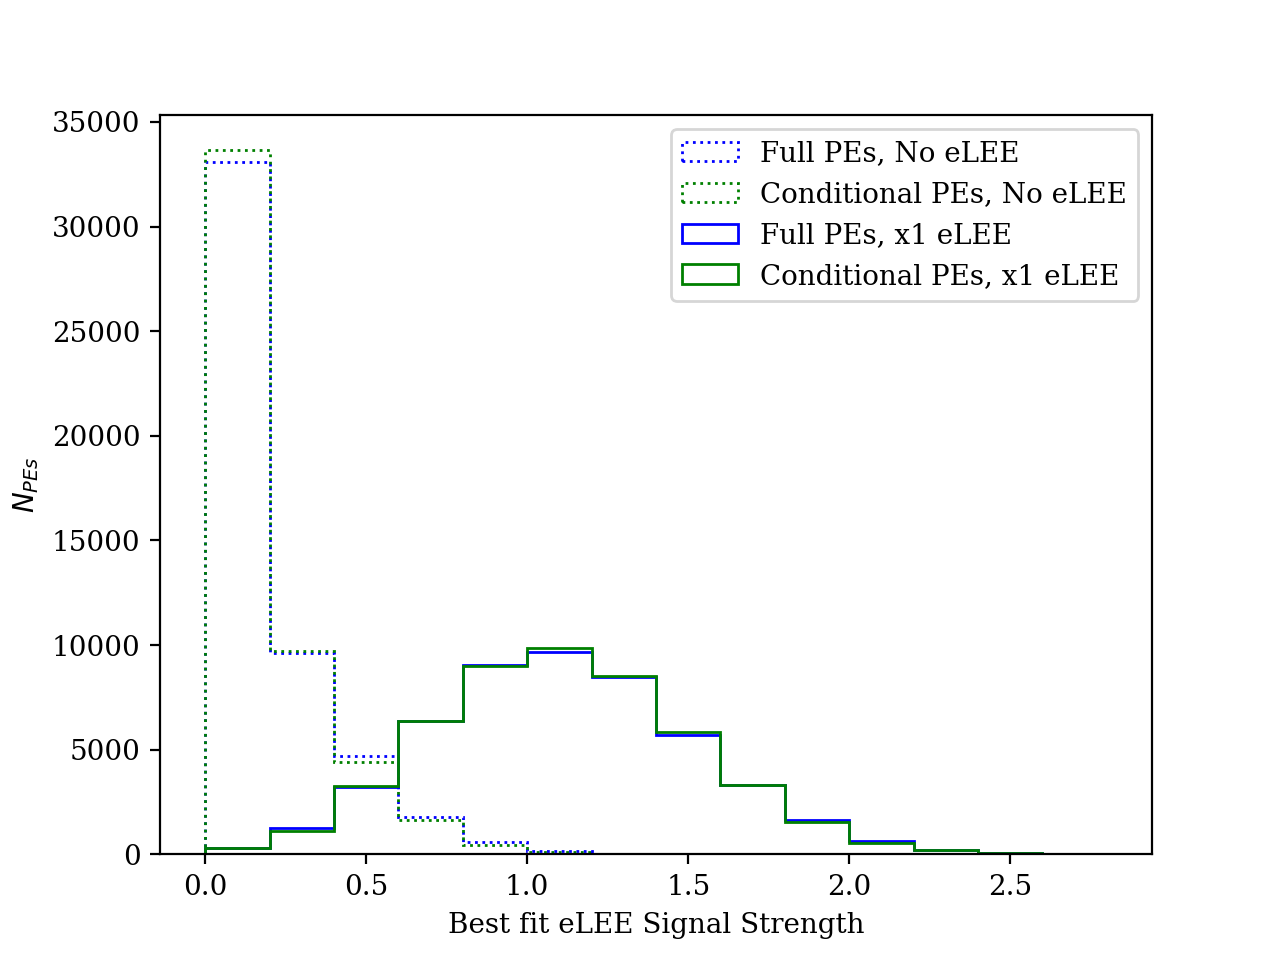

In [141]:
fig,ax = plt.subplots()

bins=np.arange(0,3.0,0.2)

ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["mu_fit"],bins=bins,label="Full PEs, No eLEE",color='b',histtype="step",linestyle="dotted")
ax.hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["mu_fit"],bins=bins,label="Conditional PEs, No eLEE",color='g',histtype="step",linestyle="dotted")
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["mu_fit"],bins=bins,label="Full PEs, x1 eLEE",color='b',histtype="step")
ax.hist(df_pes_cond.query("abs(mu_true-1.0)<0.001")["mu_fit"],bins=bins,label="Conditional PEs, x1 eLEE",color='g',histtype="step")
#ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond"],bins=bins,label="Full PEs, Conditional $\chi^2$",color='b',histtype="step",linestyle="dashed")
#ax.hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_hb"],bins=bins,label="Constrained PEs, Original $\chi^2$",color='g',histtype="step")
#ax.hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_h0"],bins=bins,label="Constrained PEs, Conditional $\chi^2$",color='g',histtype="step",linestyle="dashed")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP,M_COV_NUE_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Original $\chi^2$")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Conditional $\chi^2$",linestyle="dashed")

ax.set_xlabel("Best fit eLEE Signal Strength")
ax.set_ylabel("$N_{PEs}$")
ax.legend()

#plt.title("x2 eLEE signal")
plt.show()
plt.savefig(tmp_plot(ftype="png"))

<IPython.core.display.Javascript object>


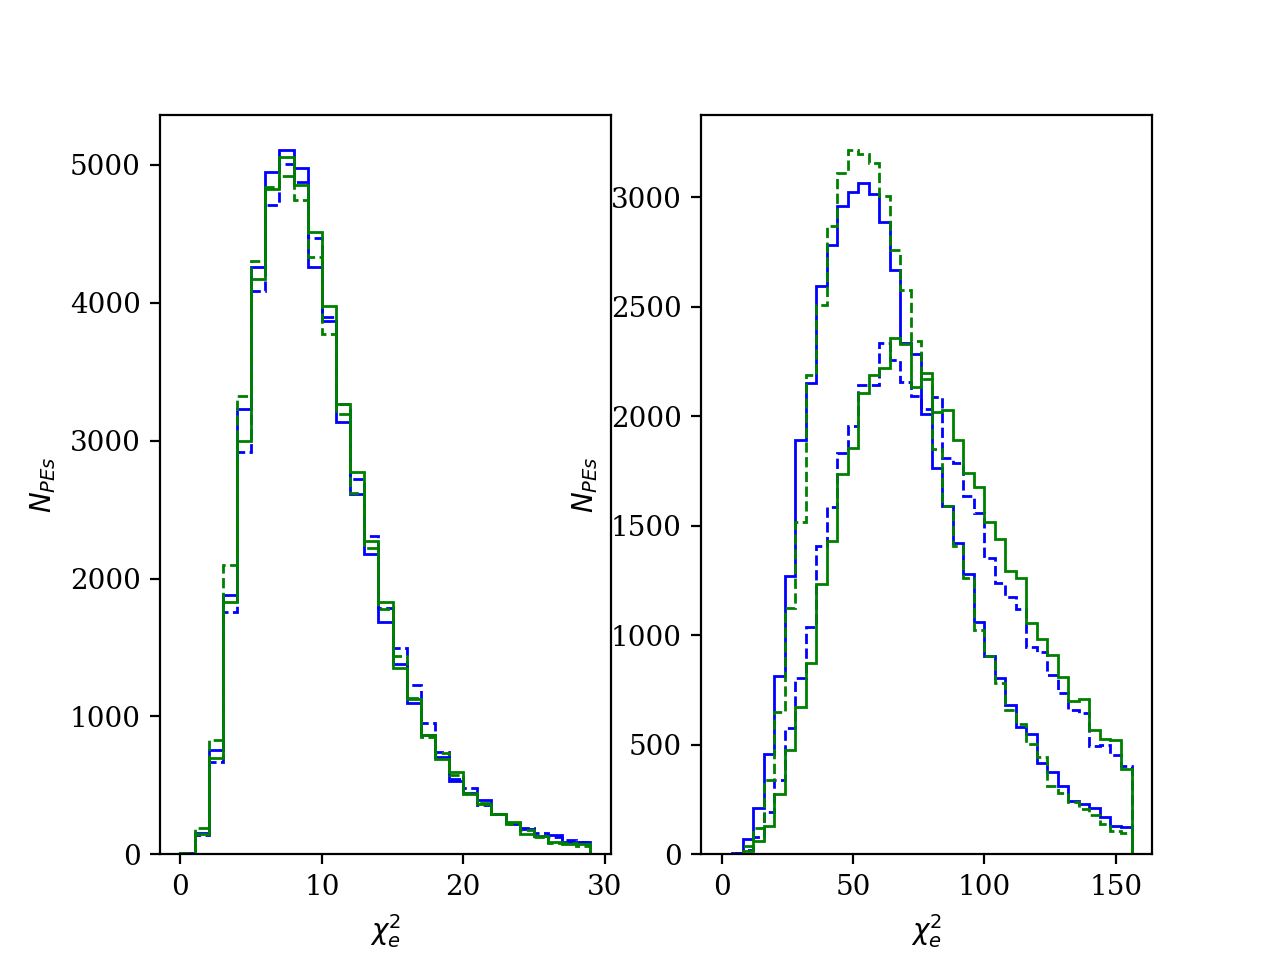

In [102]:
fig,ax = plt.subplots(1,2)

bins=np.arange(0,30,1)

ax[0].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_nue"],bins=bins,label="PEs From Full",histtype="step")
ax[0].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond"],bins=bins,label="PEs From Full",histtype="step",color='b',linestyle='--')
ax[0].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_nue"],bins=bins,label="PEs From Constrained",histtype="step",linestyle='--')
ax[0].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_h0"],bins=bins,label="PEs From Constrained",histtype="step",color='g')
#ax.vlines(x=CHI2(NUMU_OBS-NUMU_EXP,M_COV_NUMU_INV),ymin=0,ymax=1000,color="r")

ax[0].set_xlabel("$\chi^2_{e}$")
ax[0].set_ylabel("$N_{PEs}$")

bins2=np.arange(0,160,4)

ax[1].hist(df_pes_tot.query("abs(mu_true-2.0)<0.001")["chi2_nue"],bins=bins2,label="PEs From Full",histtype="step")
ax[1].hist(df_pes_tot.query("abs(mu_true-2.0)<0.001")["chi2_cond"],bins=bins2,label="PEs From Full",histtype="step",color='b',linestyle='--')
ax[1].hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_nue"],bins=bins2,label="PEs From Constrained",histtype="step",linestyle='--')
ax[1].hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_h0"],bins=bins2,label="PEs From Constrained",histtype="step",color='g')
#ax.vlines(x=CHI2(NUMU_OBS-NUMU_EXP,M_COV_NUMU_INV),ymin=0,ymax=1000,color="r")

ax[1].set_xlabel("$\chi^2_{e}$")
ax[1].set_ylabel("$N_{PEs}$")

plt.show()
plt.savefig(tmp_plot())

In [ ]:
print(SIG_EXP_COND/SIG_EXP[:10])
print(SIG_EXP[:10])

In [ ]:
chi2(nue_obs-nue_exp_cond,np.linalg.inv(m_cov_cond))

In [ ]:
print(nue_exp_cond)
print(m_cov_cond)
print(m_cov_cond_sys)

In [ ]:
for i in range(20):
    my_pe = get_pe(nue_exp_cond, m_cov_cond_sys)
    print(my_pe)
    print(chi2(my_pe-nue_exp_cond,np.linalg.inv(m_cov_cond)))

In [ ]:
df_pes_cond = pd.DataFrame()
for x in true_vals:
    print("\tRunning x=%f"%x)
    df_pes_cond = df_pes_cond.append(run_pes(n_pes,x,nue_exp_cond,sig_exp_cond[:10],m_cov_cond_sys))

In [ ]:
df_pes_cond

In [ ]:
df_pes_tot

In [ ]:
def get_fc_interval(chi2_diff,true_vals,critical_vals):
    vals = np.where(chi2_diff<critical_vals,true_vals,np.nan)
    vals = vals[~np.isnan(vals)]
    return (np.amin(vals),np.amax(vals),vals)
def get_fc_interval_min(chi2_diff,true_vals,critical_vals):
    vals = np.where(chi2_diff<critical_vals,true_vals,np.nan)
    vals = vals[~np.isnan(vals)]
    if len(vals)==0:
        return -1
    return np.amin(vals)
def get_fc_interval_max(chi2_diff,true_vals,critical_vals):
    vals = np.where(chi2_diff<critical_vals,true_vals,np.nan)
    vals = vals[~np.isnan(vals)]
    if len(vals)==0:
        return 9999
    return np.amax(vals)

In [ ]:
def chi2_diff(data,x_vals,sig,bkg,m_cov_inv):
    x0 = [0.1]
    res = scipy.optimize.minimize(chi2_sig,x0,
                                  args=(data,
                                        sig,
                                        bkg,
                                        m_cov_inv),
                                        bounds=[(0,100.)])
    chi2_hb_obs = chi2_sig(res.x[0],data=data,sig=sig,bkg=bkg,m_cov_inv=m_cov_inv)
    
    chi2_diff = np.empty(len(x_vals))
    for ix in range(len(x_vals)):
        chi2_diff[ix] = chi2_sig(x_vals[ix],data=data,sig=sig,bkg=bkg,m_cov_inv=m_cov_inv)-chi2_hb_obs
    return chi2_diff


In [ ]:
df_tmp

In [ ]:
def add_fc_intervals(df_pes,x_vals,critical_vals,sig,bkg,m_cov_inv):
    df_pes["fc_interval_min_s1"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_min(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[0]))
    df_pes["fc_interval_max_s1"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_max(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[0]))
    df_pes["fc_interval_min_s2"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_min(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[1]))
    df_pes["fc_interval_max_s2"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_max(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[1]))
    #df_pes["fc_interval_min_s3"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_min(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[2]))
    #df_pes["fc_interval_max_s3"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_max(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[2]))
    
    df_pes["true_contained_s1"] = np.logical_and(df_pes["mu_true"]>=df_pes["fc_interval_min_s1"],
                                                 df_pes["mu_true"]<=df_pes["fc_interval_max_s1"])
    df_pes["true_contained_s2"] = np.logical_and(df_pes["mu_true"]>=df_pes["fc_interval_min_s2"],
                                                 df_pes["mu_true"]<=df_pes["fc_interval_max_s2"])
    #df_pes["true_contained_s3"] = np.logical_and(df_pes["mu_true"]>=df_pes["fc_interval_min_s3"],
    #                                             df_pes["mu_true"]<=df_pes["fc_interval_max_s3"])
    return df_pes

In [ ]:
diff_obs = chi2_diff(df_pes_tot.iloc[1]["pe_data"],true_vals,sig_exp,data_exp,m_cov_inv)

In [ ]:
for cval in critical_vals_tot:
    print(get_fc_interval(diff_obs,true_vals,cval))

In [ ]:
df_tmp = df_pes_tot.iloc[:10].copy()

In [ ]:
df_pes_tot = add_fc_intervals(df_pes_tot,true_vals,critical_vals_tot,sig_exp,data_exp,m_cov_inv)

In [ ]:
df_pes_cond["intervals"] = df_pes_cond["pe_data"].apply(lambda pe: calc_fc_interval_numba(pe,true_vals,sig_exp[:10],nue_exp_cond,np.linalg.inv(m_cov_cond),critical_vals_cond))

In [ ]:
df_pes_cond

In [ ]:
calc_fc_interval_numba(nue_obs,true_vals,sig_exp_cond[:10],nue_exp_cond,np.linalg.inv(m_cov_cond),critical_vals_cond)

In [ ]:
calc_fc_interval_numba(data_obs,true_vals,sig_exp,data_exp,np.linalg.inv(m_cov),critical_vals_tot)

In [ ]:
x0 = [0.1]
res = scipy.optimize.minimize(chi2_sig,x0,
                              args=(data_obs,
                                    sig_exp,
                                    data_exp,
                                    m_cov_inv),
                                    bounds=[(0,100.)])
print(res)

In [ ]:
x0 = [0.1]
res = scipy.optimize.minimize(chi2_sig,x0,
                              args=(nue_obs,
                                    sig_exp_cond,
                                    nue_exp_cond,
                                    np.linalg.inv(m_cov_cond)),
                                    bounds=[(0,100.)])
print(res)

In [ ]:
critical_vals_cond[0][0]

In [ ]:
critical_vals_cond[0][20]

In [ ]:
itrue = 40
qstring = "abs(mu_true-%f)<0.001"%true_vals[itrue]

df_pes_cond["mu_fit"] = df_pes_cond["mu_fit"].astype("float")
df_pes_cond["chi2_diff"] = df_pes_cond["chi2_diff"].astype("float")
res = make_profile_bins(df_pes_cond.query(qstring),0,true_vals[-1],len(true_vals),"mu_fit","chi2_diff")


fig,ax = plt.subplots()


ax.plot(res["x"],res["y"])
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[0][itrue],color='r',label="")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[1][itrue],color='r',label="")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[2][itrue],color='r',label="")


#plt.legend()
ax.set_ylabel("$\Delta\chi^2$")
ax.set_xlabel("$\mu_{fit}$")
plt.title("$\mu_{true}=%f$"%true_vals[itrue])

plt.show()
#plt.savefig("/Users/wketchum/Downloads/temp.pdf")


In [ ]:
itrue = 0
qstring = "abs(mu_true-%f)<0.001"%true_vals[itrue]

res_cond = make_profile_bins(df_pes_cond.query(qstring),0,true_vals[-1],int(len(true_vals)/2),"mu_fit","chi2_diff")
res_tot = make_profile_bins(df_pes_tot.query(qstring),0,true_vals[-1],int(len(true_vals)/2),"mu_fit","chi2_diff")


fig,ax = plt.subplots()


ax.plot(res_cond["x"],res_cond["y"],color='blue',label="Using Conditional Covariance Matrix")
ax.plot(res_tot["x"],res_tot["y"],color='black',label="Using Full Covariance Matrix")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[0][itrue],color='blue',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[1][itrue],color='blue',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[2][itrue],color='blue',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[0][itrue],color='k',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[1][itrue],color='k',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[2][itrue],color='k',linestyle="--")


plt.legend(loc=2)
ax.set_ylabel("$\Delta\chi^2$")
ax.set_xlabel("$\mu_{fit}$")
plt.title("$\mu_{true}=%f$"%true_vals[itrue])

plt.show()
plt.savefig("/Users/wketchum/Plots/temp_%d.pdf"%np.round(time.time()))

In [ ]:
def make_profile_bins(df,lowbin,hibin,nbins,xarg,yarg,option='sem',func='mean'):
    xbins = np.linspace(lowbin,hibin,nbins+1)
    diff = (xbins[1]-xbins[0])*0.00001
    xbins[-1] = xbins[-1]+diff
    result = (df[[xarg,yarg]].groupby(np.digitize(df[xarg],bins=xbins,right=False)))[yarg].agg([func,option])
    result = result.reindex(range(1,len(xbins),1))
    xbins[-1] = xbins[-1]-diff
    result["x"] = 0.5*(xbins[:-1]+xbins[1:])
    result["xerr"] = 0.5*(xbins[1]-xbins[0])
    result.rename(columns={func: 'y', option: 'yerr'}, inplace=True)
    return result

In [ ]:
itrue = 40
qstring = "abs(mu_true-%f)<0.001"%true_vals[itrue]

res_cond = make_profile_bins(df_pes_cond.query(qstring),0,true_vals[-1],len(true_vals),"mu_fit","chi2_diff",func="median")
res_tot = make_profile_bins(df_pes_tot.query(qstring),0,true_vals[-1],len(true_vals),"mu_fit","chi2_diff",func="median")

print(res_tot)

In [ ]:
res_median

In [ ]:
res_mean

In [ ]:
import time

In [ ]:
fig,ax = plt.subplots()
bins=np.arange(0,5,0.01)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.0)<0.05")["chi2_diff"],
        bins=bins,label="$0.95<\mu_{fit}<1.05$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.1)<0.05")["chi2_diff"],
        bins=bins,label="$1.05<\mu_{fit}<1.15$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.2)<0.05")["chi2_diff"],
        bins=bins,label="$1.15<\mu_{fit}<1.25$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.3)<0.05")["chi2_diff"],
        bins=bins,label="$1.25<\mu_{fit}<1.35$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.4)<0.05")["chi2_diff"],
        bins=bins,label="$1.35<\mu_{fit}<1.45$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.5)<0.05")["chi2_diff"],
        bins=bins,label="$1.45<\mu_{fit}<1.55$",histtype="step",log=True)
        

ax.set_xlabel("$\Delta\chi^2$")
ax.set_ylabel("$N_{PEs}$")

plt.legend()
plt.title("$\mu_{true}=1.0$")
plt.show()
plt.savefig("/Users/wketchum/Downloads/temp_%d.pdf"%np.round(time.time()))

In [ ]:
print(np.count_nonzero(df_pes_tot["true_contained_s1"])/len(df_pes_tot))
print(np.count_nonzero(df_pes_tot["true_contained_s2"])/len(df_pes_tot))
for x in true_vals:
    qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.0001,x+0.0001))
    print("Coverage for x=%f: 1sigma=%f, 2sigma=%f"%(x,
                                                     np.count_nonzero(df_pes_tot.query(qstring)["true_contained_s1"])/len(df_pes_tot.query(qstring)),
                                                     np.count_nonzero(df_pes_tot.query(qstring)["true_contained_s2"])/len(df_pes_tot.query(qstring))))

In [ ]:
np.logical_and(df_tmp["mu_true"]>=df_tmp["fc_interval_min_s1"],df_tmp["mu_true"]<=df_tmp["fc_interval_max_s1"])

In [ ]:
df_tmp

In [ ]:
print chi2_diff(nue_obs,)

res = scipy.optimize.minimize(chi2_sig,x0,
                                  args=(nue_obs,
                                        sig_exp,
                                        nue_exp_cond,
                                        np.linalg.inv(m_cov_cond)),
                                        bounds=[(0,100.)])

In [ ]:
fig,ax = plt.subplots()

bins=np.arange(0,100,0.5)

ax.hist(df_pes.query("mu_true==0.0")["chi2_diff"],bins=bins,color='r',label="'H0'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==1.0")["chi2_diff"],bins=bins,color='b',label="'LEE x1'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==2.0")["chi2_diff"],bins=bins,color='g',label="'LEE x2'",histtype="step",log=True)

plt.legend()
ax.set_xlabel("$\Delta\chi^2$")
ax.set_ylabel("$N_{PEs}$")

plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")

In [ ]:
fig,ax = plt.subplots()

bins=np.arange(0,10,0.1)

ax.hist(df_pes.query("mu_true==0.0")["mu_fit"],bins=bins,color='r',label="'H0'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==1.0")["mu_fit"],bins=bins,color='b',label="'LEE x1'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==2.0")["mu_fit"],bins=bins,color='g',label="'LEE x2'",histtype="step",log=True)

plt.legend()
ax.set_xlabel("Best Fit Signal Strength")
ax.set_ylabel("$N_{PEs}$")

plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")

In [ ]:
df_pes.query("mu_true==0")["chi2_diff"]

In [ ]:
for x in np.arange(0,5.0,0.1):
    qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.01,x+0.01))
    df_pes['mu_true'] = df_pes['mu_true'].astype(float)
    print("mu_true=%f"%x,np.quantile(df_pes.query(qstring)["chi2_diff"],[sigma1,sigma2,sigma3]))

In [ ]:
for x in np.arange(0,5.0,0.1):
    chi2_h0_obs = chi2(nue_obs-nue_exp_cond,np.linalg.inv(m_cov_cond))
    res = scipy.optimize.minimize(chi2_sig,x0,
                                  args=(nue_obs,
                                        sig_exp,
                                        nue_exp_cond,
                                        np.linalg.inv(m_cov_cond)),
                                        bounds=[(0,100.)])
    chi2_h1_obs = chi2_sig(x,data=nue_obs,sig=sig_exp,bkg=nue_exp_cond,m_cov_cond_inv=np.linalg.inv(m_cov_cond))
    chi2_hb_obs = chi2_sig(res.x,data=nue_obs,sig=sig_exp,bkg=nue_exp_cond,m_cov_cond_inv=np.linalg.inv(m_cov_cond))
    print("x=%f, chi2_h0_obs=%f, chi2_h1_obs=%f, chi2_hb_obs=%f, diff=%f (best fit=%f)"%(x,chi2_h0_obs,chi2_h1_obs,chi2_hb_obs,chi2_h1_obs-chi2_hb_obs,res.x[0]))

In [ ]:
hist_mu_00,bins = np.histogram(df_pes.query("mu_true==0")["mu_fit"].astype(float),bins=np.arange(0,10,0.1))

In [ ]:
hist_mu_00

In [ ]:
bins

In [ ]:
np.argmax(hist_mu_00[1:])+1

In [ ]:
def interval(df,level,prec=0.01):
    n_pes = len(df)
    hist_mu,bins = np.histogram(df,bins=np.arange(0,500,prec))
    init_max = np.argmax(hist_mu[1:])+1
    ilo = init_max
    ihi = init_max
    integral = hist_mu[init_max]
    
    while(integral < level*n_pes):
        if ilo==0:
            ihi += 1
            integral += hist_mu[ihi]
        elif(ihi==len(bins)-1):
            ilo -= 1
            integral += hist_mu[ilo]
        elif hist_mu[ilo-1]>hist_mu[ihi+1]:
            ilo -= 1
            integral += hist_mu[ilo]
        elif hist_mu[ilo-1]<=hist_mu[ihi+1]:
            ihi += 1
            integral += hist_mu[ihi]
    return bins[ilo], bins[ihi]+0.1, (integral/n_pes)

In [ ]:
interval(df_pes.query("mu_true==0.0")["mu_fit"],level=0.67)

In [ ]:
for x in np.arange(0,5.0,0.1):
    qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.01,x+0.01))
    df_pes['mu_true'] = df_pes['mu_true'].astype(float)
    lo, hi, coverage = interval(df_pes.query(qstring)["mu_fit"],level=0.67)
    print("For true signal strength %f: %f < mu_fit < %f (coverage=%f)"%(x,lo,hi,coverage))

In [ ]:
chi2_h0_obs = chi2(nue_obs-nue_exp_cond,np.linalg.inv(m_cov_cond))
res = scipy.optimize.minimize(chi2_sig,x0,
                              args=(nue_obs,
                                    sig_exp,
                                    nue_exp_cond,
                                    np.linalg.inv(m_cov_cond)),
                                    bounds=[(0,100.)])
chi2_h1_obs = chi2_sig(res.x,data=nue_obs,sig=sig_exp,bkg=nue_exp_cond,m_cov_cond_inv=np.linalg.inv(m_cov_cond))
print("chi2_h0_obs=%f, chi2_h1_obs=%f, diff=%f (best fit=%f)"%(chi2_h0_obs,chi2_h1_obs,chi2_h0_obs-chi2_h1_obs,res.x[0]))

In [ ]:
len(df_pes.query("mu_true==0 and mu_fit>0.683232"))/len(df_pes.query("mu_true==0"))

In [ ]:
def confidence_bands(x_vals,df_pes,level,var="mu_fit",prec=0.01,verbose=False):
    x_lo = []
    x_hi = []
    for x in x_vals:
        qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.001,x+0.001))
        df_pes['mu_true'] = df_pes['mu_true'].astype(float)
        lo, hi, coverage = interval(df_pes.query(qstring)[var],level,prec)
        x_lo.append(lo)
        x_hi.append(hi)
        if verbose:
            print("For true signal strength %f: %f < mu_fit < %f (coverage=%f)"%(x,lo,hi,coverage))
    return x_lo, x_hi

In [ ]:
x_vals = np.arange(0,5.,0.1)
sigma1 = scipy.stats.norm(0,1).cdf(1)-scipy.stats.norm(0,1).cdf(-1)
sigma2 = scipy.stats.norm(0,1).cdf(2)-scipy.stats.norm(0,1).cdf(-2)
sigma3 = scipy.stats.norm(0,1).cdf(3)-scipy.stats.norm(0,1).cdf(-3)

x_lo1, x_hi1 = confidence_bands(x_vals,df_pes,level=sigma1,prec=0.05)
x_lo2, x_hi2 = confidence_bands(x_vals,df_pes,level=sigma2,prec=0.05)
x_lo3, x_hi3 = confidence_bands(x_vals,df_pes,level=sigma3,prec=0.05)

In [ ]:
len(df_pes.query("mu_true==0 and chi2_diff>4.686515"))/len(df_pes.query("mu_true==0"))

In [ ]:
fig,ax = plt.subplots()

ax.plot(x_lo1,x_vals,color='b',label="$1\sigma$")
ax.plot(x_hi1,x_vals,color='b')

ax.plot(x_lo2,x_vals,color='b',linestyle="--",label="$2\sigma$")
ax.plot(x_hi2,x_vals,color='b',linestyle="--")

ax.plot(x_lo3,x_vals,color='b',linestyle="dotted",label="$3\sigma$")
ax.plot(x_hi3,x_vals,color='b',linestyle="dotted")

ax.vlines(x=res.x[0],ymin=x_vals[0],ymax=x_vals[-1],color='r',label="Observed, Fake Dataset2")

plt.legend(loc=4)
ax.set_xlabel("Fit Signal Strength")
ax.set_ylabel("True Signal Strength")

plt.grid(True)
plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")

In [ ]:
x_vals = np.arange(0,5.,0.1)
sigma1 = scipy.stats.norm(0,1).cdf(1)-scipy.stats.norm(0,1).cdf(-1)
sigma2 = scipy.stats.norm(0,1).cdf(2)-scipy.stats.norm(0,1).cdf(-2)
sigma3 = scipy.stats.norm(0,1).cdf(3)-scipy.stats.norm(0,1).cdf(-3)

x_lo1, x_hi1 = confidence_bands(x_vals,df_pes,level=sigma1,var="chi2_diff",prec=1.)
x_lo2, x_hi2 = confidence_bands(x_vals,df_pes,level=sigma2,var="chi2_diff",prec=1.)
#x_lo3, x_hi3 = confidence_bands(x_vals,df_pes,level=sigma3,var="chi2_diff",prec=1.)

In [ ]:
fig,ax = plt.subplots()

ax.plot(x_lo1,x_vals,color='b',label="$1\sigma$")
ax.plot(x_hi1,x_vals,color='b')

ax.plot(x_lo2,x_vals,color='b',linestyle="--",label="$2\sigma$")
ax.plot(x_hi2,x_vals,color='b',linestyle="--")

#ax.plot(x_lo3,x_vals,color='b',linestyle="dotted",label="$3\sigma$")
#ax.plot(x_hi3,x_vals,color='b',linestyle="dotted")

ax.vlines(x=(chi2_h0_obs-chi2_h1_obs),ymin=x_vals[0],ymax=x_vals[-1],color='r',label="Observed, Fake Dataset2")

plt.legend(loc=4)
ax.set_xlabel("$\Delta\chi^2$")
ax.set_ylabel("True Signal Strength")

ax.set_xlim(left=0.,right=100.)
plt.grid(True)
plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")